<a href="https://colab.research.google.com/github/EduardoAve/An-lisis-descriptivo-de-matr-cula/blob/main/analisis_descriptivo_CIEAVC_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Descriptivo de Población Estudiantil
## Sedes Educativas CIEAVC (2019 - 2025)

Este notebook realiza un análisis descriptivo de la población estudiantil matriculada en 50 sedes educativas, utilizando datos del **SIMAT** (matrícula, 2019-2025) y **SIMPADE** (deserción, 2020-2025).

### Variables analizadas:
- Estrato socioeconómico
- Edad
- Género
- Población víctima del conflicto
- Discapacidad
- Etnia
- Grado y nivel educativo
- Repitencia
- Cabeza de familia y beneficiario madre cabeza de familia
- Índice de deserción (SIMPADE)

---
## 1. Carga de datos y configuración

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# --- Paleta de colores Viridis personalizada ---
palette = [
    "#440154FF", "#481567FF", "#482677FF", "#453781FF", "#404788FF",
    "#39568CFF", "#33638DFF", "#2D708EFF", "#287D8EFF", "#238A8DFF",
    "#1F968BFF", "#20A387FF", "#29AF7FFF", "#3CBB75FF", "#55C667FF",
    "#73D055FF", "#95D840FF", "#B8DE29FF", "#DCE319FF", "#FDE725FF",
]

# Configuración global de estilo
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# --- Carga de datos ---
SIMAT = pd.read_excel("/content/drive/MyDrive/reportes 2026/reporte NIKI 2/DATASET_SIMAT_CIEAVC_2019_2025.xlsx")
SIMPADE = pd.read_excel("/content/drive/MyDrive/reportes 2026/reporte NIKI 2/DATASET_SIMPADE_CIEAVC_2019_2025.xlsx")

print(f"SIMAT: {SIMAT.shape[0]:,} registros, {SIMAT.shape[1]} columnas")
print(f"SIMPADE: {SIMPADE.shape[0]:,} registros, {SIMPADE.shape[1]} columnas")
print(f"\nAños SIMAT: {sorted(SIMAT['ANO_INF'].unique())}")
print(f"Años SIMPADE: {sorted(SIMPADE['ANNO_INF'].unique())}")

SIMAT: 224,300 registros, 79 columnas
SIMPADE: 10,807 registros, 7 columnas

Años SIMAT: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Años SIMPADE: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


---
## 2. Transformación y preparación de variables

In [3]:
# ============================================================
# 2.1 EDAD: Calcular desde FECHA_NACIMIENTO hasta 1 de noviembre del ANO_INF
# ============================================================
SIMAT['FECHA_NACIMIENTO'] = pd.to_datetime(SIMAT['FECHA_NACIMIENTO'], errors='coerce')
SIMAT['FECHA_CORTE'] = pd.to_datetime(SIMAT['ANO_INF'].astype(str) + '-11-01')
SIMAT['EDAD'] = pd.to_numeric(
    (SIMAT['FECHA_CORTE'] - SIMAT['FECHA_NACIMIENTO']).dt.days / 365.25,
    errors='coerce'
).round(0).astype('Int64')

# ============================================================
# 2.2 ESTRATO: Recodificar 0 y 9 como 'No aplica'
# ============================================================
SIMAT['ESTRATO_CAT'] = SIMAT['ESTRATO'].apply(
    lambda x: 'No aplica' if x in [0, 9] else f'Estrato {int(x)}' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.3 VÍCTIMA DEL CONFLICTO: 99 = No víctima, resto = Víctima
# ============================================================
SIMAT['VICTIMA'] = SIMAT['POB_VICT_CONF'].apply(
    lambda x: 'No víctima' if x == 99 else 'Víctima' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.4 DISCAPACIDAD: 99 = Sin discapacidad, resto = Con discapacidad
# ============================================================
SIMAT['DISCAPACIDAD'] = SIMAT['TIPO_DISCAPACIDAD'].apply(
    lambda x: 'Sin discapacidad' if x == 99 else 'Con discapacidad' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.5 ETNIA: Clasificar en 4 categorías
# ============================================================
def clasificar_etnia(codigo):
    if pd.isna(codigo):
        return 'Sin dato'
    codigo = int(codigo)
    if codigo == 0:
        return 'No autoreconocimiento'
    elif codigo == 400:
        return 'Rrom'
    elif codigo in [97, 98, 200]:
        return 'Afrodescendiente'
    else:
        return 'Indígena'

SIMAT['ETNIA_CAT'] = SIMAT['ETNIA'].apply(clasificar_etnia)

# ============================================================
# 2.6 NIVEL EDUCATIVO: Agrupar grados
# ============================================================
def clasificar_nivel(grado):
    if pd.isna(grado):
        return 'Sin dato'
    grado = int(grado)
    if grado in [-2, -1, 0]:
        return 'Educación inicial'
    elif 1 <= grado <= 5:
        return 'Básica primaria'
    elif 6 <= grado <= 9:
        return 'Básica secundaria'
    elif grado in [10, 11]:
        return 'Media'
    elif 21 <= grado <= 26:
        return 'Ciclos de adultos'
    elif grado == 99:
        return 'Aceleración del aprendizaje'
    else:
        return 'Otro'

SIMAT['NIVEL_EDUCATIVO'] = SIMAT['GRADO'].apply(clasificar_nivel)

print("Transformaciones completadas exitosamente.")
print(f"\nDistribución de Etnia: {SIMAT['ETNIA_CAT'].value_counts().to_dict()}")
print(f"Distribución de Nivel Educativo: {SIMAT['NIVEL_EDUCATIVO'].value_counts().to_dict()}")

Transformaciones completadas exitosamente.

Distribución de Etnia: {'No autoreconocimiento': 125564, 'Afrodescendiente': 97594, 'Indígena': 1134, 'Rrom': 8}
Distribución de Nivel Educativo: {'Básica primaria': 91829, 'Básica secundaria': 70655, 'Media': 25792, 'Ciclos de adultos': 17986, 'Educación inicial': 14366, 'Aceleración del aprendizaje': 3672}


---
## 3. Funciones auxiliares de visualización

In [4]:
def formato_miles(x, pos):
    """Formato para ejes: 1000 -> 1,000"""
    return f'{int(x):,}'

def grafico_barras(data, x_col, titulo, xlabel, ylabel='Número de estudiantes',
                   orden=None, horizontal=False, color_idx=0, figsize=(12, 6), rotation=0,
                   mostrar_valores=True, ax=None):
    """Gráfico de barras reutilizable con estilo consistente."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    conteo = data[x_col].value_counts()
    if orden is not None:
        conteo = conteo.reindex(orden).dropna()

    n_barras = len(conteo)
    colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]

    if horizontal:
        bars = ax.barh(conteo.index.astype(str), conteo.values, color=colores, edgecolor='white')
        ax.set_xlabel(ylabel)
        ax.set_ylabel(xlabel)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
        if mostrar_valores:
            for bar, val in zip(bars, conteo.values):
                ax.text(val + conteo.max()*0.01, bar.get_y() + bar.get_height()/2,
                        f'{int(val):,}', va='center', fontsize=9)
    else:
        bars = ax.bar(conteo.index.astype(str), conteo.values, color=colores, edgecolor='white')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
        ax.tick_params(axis='x', rotation=rotation)
        if mostrar_valores:
            for bar, val in zip(bars, conteo.values):
                ax.text(bar.get_x() + bar.get_width()/2, val + conteo.max()*0.01,
                        f'{int(val):,}', ha='center', va='bottom', fontsize=9)

    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=15)
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    return ax


def grafico_lineas_temporal(data, variable, titulo, ylabel='Número de estudiantes',
                            ano_col='ANO_INF', figsize=(12, 6), porcentaje=False):
    """Gráfico de líneas para evolución temporal de una variable categórica."""
    fig, ax = plt.subplots(figsize=figsize)

    tabla = data.groupby([ano_col, variable]).size().unstack(fill_value=0)
    if porcentaje:
        tabla = tabla.div(tabla.sum(axis=1), axis=0) * 100
        ylabel = 'Porcentaje (%)'

    n_cats = len(tabla.columns)
    colores = [palette[int(i * (len(palette)-1) / max(n_cats-1, 1))] for i in range(n_cats)]

    for i, col in enumerate(tabla.columns):
        ax.plot(tabla.index, tabla[col], marker='o', linewidth=2.5, markersize=7,
                label=col, color=colores[i])
        # Etiqueta en el último punto
        ultimo_val = tabla[col].iloc[-1]
        if porcentaje:
            ax.annotate(f'{ultimo_val:.1f}%', (tabla.index[-1], ultimo_val),
                        textcoords='offset points', xytext=(10, 0), fontsize=9)
        else:
            ax.annotate(f'{int(ultimo_val):,}', (tabla.index[-1], ultimo_val),
                        textcoords='offset points', xytext=(10, 0), fontsize=9)

    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Año')
    ax.set_ylabel(ylabel)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    ax.set_xticks(sorted(data[ano_col].unique()))
    ax.spines[['top', 'right']].set_visible(False)
    if not porcentaje:
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
    plt.tight_layout()
    plt.show()


def tabla_resumen(data, variable, ano_col='ANO_INF'):
    """Genera tabla resumen con conteos y porcentajes por año."""
    tabla = data.groupby([ano_col, variable]).size().unstack(fill_value=0)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

    # Combinar conteo y porcentaje
    resultado = pd.DataFrame()
    for col in tabla.columns:
        resultado[f'{col} (n)'] = tabla[col].apply(lambda x: f'{int(x):,}')
        resultado[f'{col} (%)'] = tabla_pct[col].apply(lambda x: f'{x:.1f}%')

    resultado.index.name = 'Año'
    return resultado

print("Funciones de visualización cargadas.")

Funciones de visualización cargadas.


---
## 4. Matrícula total por año

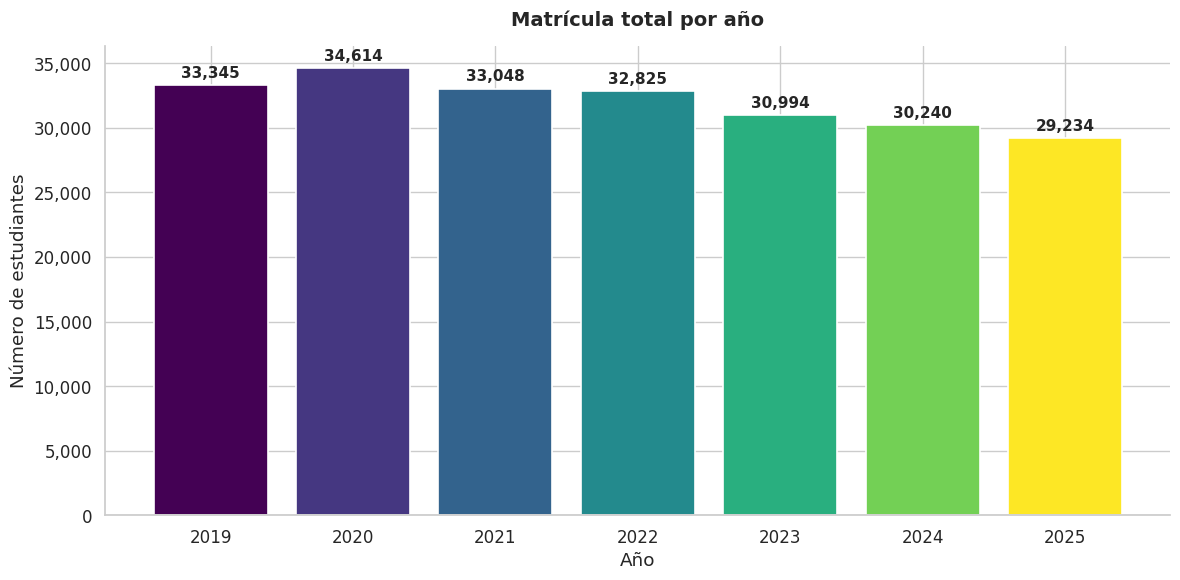


Tabla resumen:


,Total
ANO_INF,
2019,"33,345"
2020,"34,614"
2021,"33,048"
2022,"32,825"
2023,"30,994"
2024,"30,240"
2025,"29,234"


In [5]:
# Matrícula total por año
matricula_anual = SIMAT.groupby('ANO_INF').size().reset_index(name='Total')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(matricula_anual['ANO_INF'].astype(str), matricula_anual['Total'],
              color=[palette[int(i * (len(palette)-1) / max(len(matricula_anual)-1, 1))]
                     for i in range(len(matricula_anual))],
              edgecolor='white', linewidth=1.2)

for bar, val in zip(bars, matricula_anual['Total']):
    ax.text(bar.get_x() + bar.get_width()/2, val + matricula_anual['Total'].max()*0.01,
            f'{int(val):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Matrícula total por año', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

print("\nTabla resumen:")
display(matricula_anual.set_index('ANO_INF').style.format({'Total': '{:,}'}))

---
## 5. Distribución por Estrato Socioeconómico

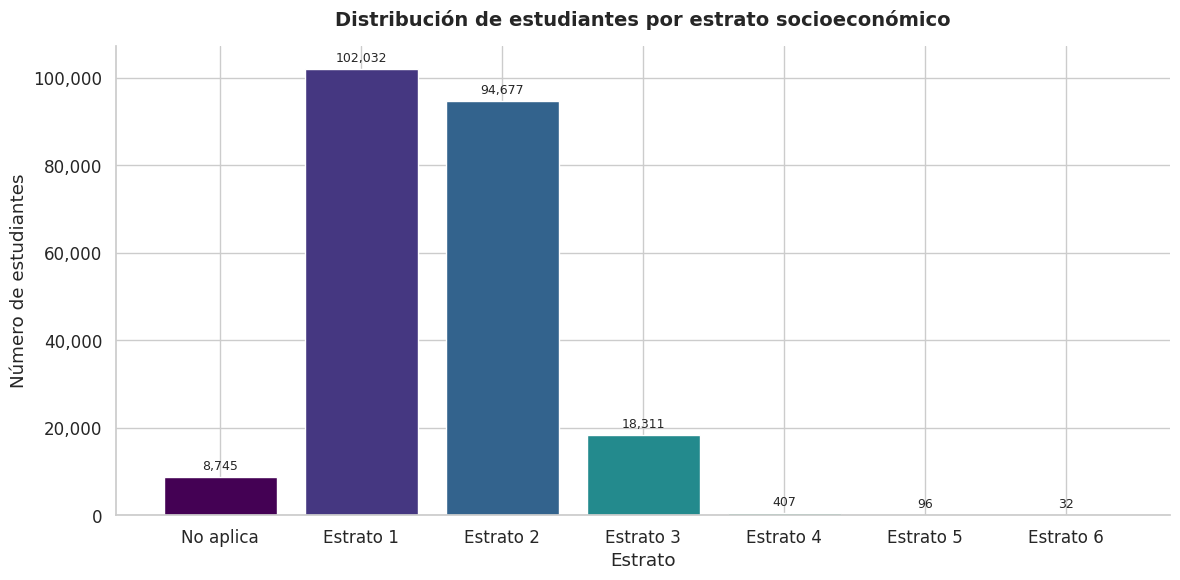


Tabla resumen - Estrato por año:


,Estrato 1 (n),Estrato 1 (%),Estrato 2 (n),Estrato 2 (%),Estrato 3 (n),Estrato 3 (%),Estrato 4 (n),Estrato 4 (%),Estrato 5 (n),Estrato 5 (%),Estrato 6 (n),Estrato 6 (%),No aplica (n),No aplica (%)
Año,,,,,,,,,,,,,,
2019,"15,393",46.2%,"14,338",43.0%,"2,610",7.8%,53,0.2%,17,0.1%,6,0.0%,928,2.8%
2020,"15,733",45.5%,"14,794",42.7%,"2,933",8.5%,46,0.1%,13,0.0%,7,0.0%,"1,088",3.1%
2021,"14,696",44.5%,"14,335",43.4%,"2,811",8.5%,56,0.2%,11,0.0%,4,0.0%,"1,135",3.4%
2022,"14,859",45.3%,"13,836",42.2%,"2,712",8.3%,63,0.2%,15,0.0%,5,0.0%,"1,335",4.1%
2023,"14,211",45.9%,"12,787",41.3%,"2,548",8.2%,60,0.2%,12,0.0%,5,0.0%,"1,371",4.4%
2024,"13,996",46.3%,"12,370",40.9%,"2,342",7.7%,61,0.2%,15,0.0%,3,0.0%,"1,453",4.8%
2025,"13,144",45.0%,"12,217",41.8%,"2,355",8.1%,68,0.2%,13,0.0%,2,0.0%,"1,435",4.9%


In [6]:
# Orden de estratos
orden_estrato = ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']

# --- Gráfico general ---
fig, ax = plt.subplots(figsize=(12, 6))
grafico_barras(SIMAT, 'ESTRATO_CAT', 'Distribución de estudiantes por estrato socioeconómico',
               'Estrato', orden=orden_estrato, ax=ax)
plt.show()

# --- Tabla resumen por año ---
print("\nTabla resumen - Estrato por año:")
display(tabla_resumen(SIMAT, 'ESTRATO_CAT'))

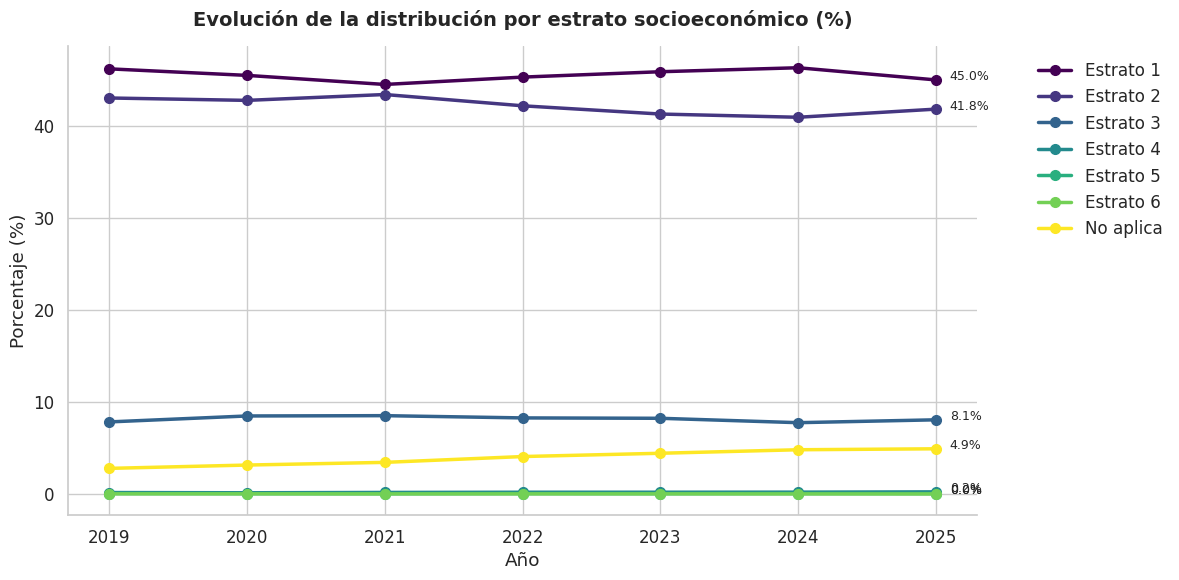

In [7]:
# --- Evolución temporal del estrato (porcentaje) ---
grafico_lineas_temporal(SIMAT, 'ESTRATO_CAT',
                        'Evolución de la distribución por estrato socioeconómico (%)',
                        porcentaje=True)

---
## 6. Distribución por Edad

Estadísticas descriptivas de la edad:
         count       mean       std  min  25%   50%   75%   max
EDAD  224300.0  12.903736  5.871024  4.0  9.0  12.0  16.0  90.0


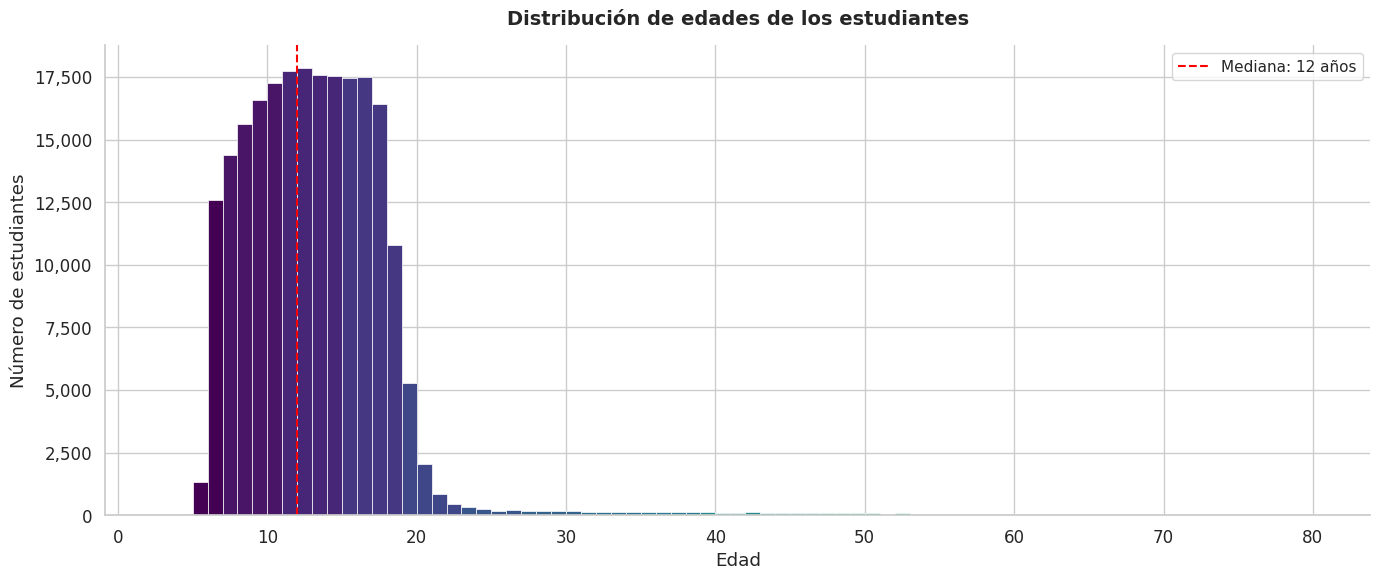

In [8]:
# Estadísticas descriptivas de edad
print("Estadísticas descriptivas de la edad:")
print(SIMAT['EDAD'].describe().to_frame().T.to_string())

# --- Histograma de edades (todos los años) ---
fig, ax = plt.subplots(figsize=(14, 6))
edades_validas = SIMAT['EDAD'].dropna()
edades_validas = edades_validas[(edades_validas >= 3) & (edades_validas <= 80)]  # Filtro razonable

n, bins, patches = ax.hist(edades_validas, bins=range(3, 81), edgecolor='white', linewidth=0.5)
# Colorear barras con la paleta
for i, patch in enumerate(patches):
    color_idx = int(i * (len(palette)-1) / max(len(patches)-1, 1))
    patch.set_facecolor(palette[color_idx])

ax.set_title('Distribución de edades de los estudiantes', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Edad')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)

# Línea de mediana
mediana = edades_validas.median()
ax.axvline(mediana, color='red', linestyle='--', linewidth=1.5, label=f'Mediana: {mediana:.0f} años')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

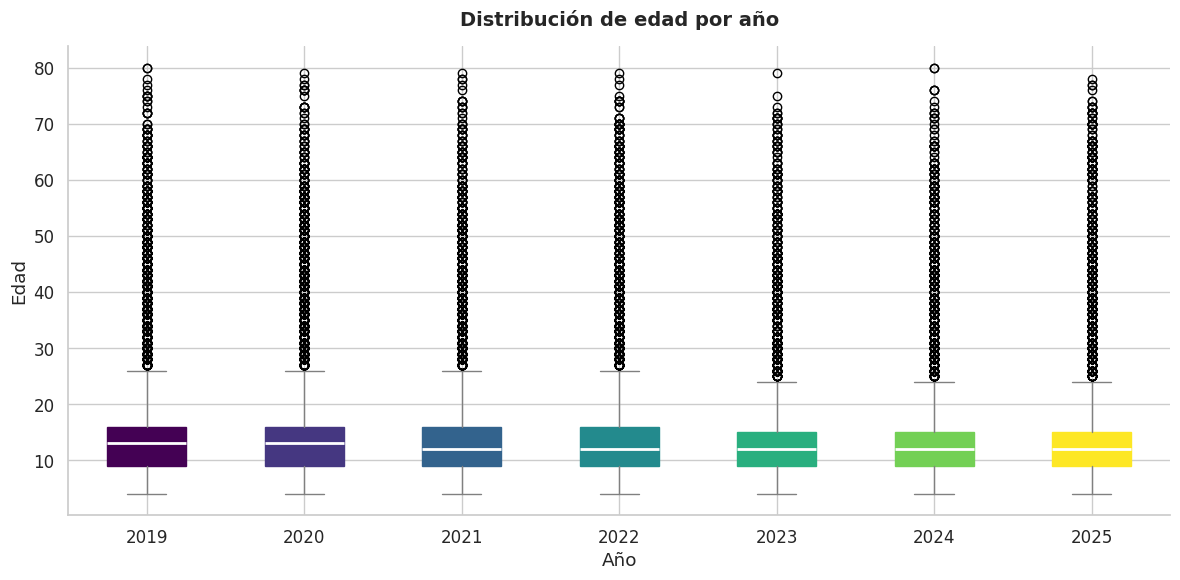


Estadísticas de edad por año:


,N,Media,Desv. Est.,Mín,Q1,Mediana,Q3,Máx
ANO_INF,,,,,,,,
2019,"33,345",13.1,6.1,4.0,9.0,13.0,16.0,80.0
2020,"34,614",13.2,6.2,4.0,9.0,13.0,16.0,81.0
2021,"33,048",12.9,5.8,4.0,9.0,12.0,16.0,81.0
2022,"32,825",13.0,6.0,4.0,9.0,12.0,16.0,83.0
2023,"30,994",12.7,5.4,4.0,9.0,12.0,15.0,90.0
2024,"30,240",12.7,5.5,4.0,9.0,12.0,15.0,82.0
2025,"29,234",12.8,5.9,4.0,9.0,12.0,15.0,85.0


In [9]:
# --- Boxplot de edad por año ---
fig, ax = plt.subplots(figsize=(12, 6))
anos = sorted(SIMAT['ANO_INF'].unique())
data_box = [SIMAT.loc[(SIMAT['ANO_INF'] == a) & (SIMAT['EDAD'].between(3, 80)), 'EDAD'].dropna() for a in anos]

bp = ax.boxplot(data_box, labels=[str(a) for a in anos], patch_artist=True,
                medianprops=dict(color='white', linewidth=2),
                whiskerprops=dict(color='gray'),
                capprops=dict(color='gray'))

n_box = len(bp['boxes'])
for i, box in enumerate(bp['boxes']):
    color_idx = int(i * (len(palette)-1) / max(n_box-1, 1))
    box.set_facecolor(palette[color_idx])
    box.set_edgecolor(palette[color_idx])

ax.set_title('Distribución de edad por año', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Edad')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen de edad por año
print("\nEstadísticas de edad por año:")
tabla_edad = SIMAT.groupby('ANO_INF')['EDAD'].describe()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
tabla_edad.columns = ['N', 'Media', 'Desv. Est.', 'Mín', 'Q1', 'Mediana', 'Q3', 'Máx']
tabla_edad['N'] = tabla_edad['N'].apply(lambda x: f'{int(x):,}')
tabla_edad[['Media', 'Desv. Est.']] = tabla_edad[['Media', 'Desv. Est.']].round(1)
display(tabla_edad)

---
## 7. Distribución por Género

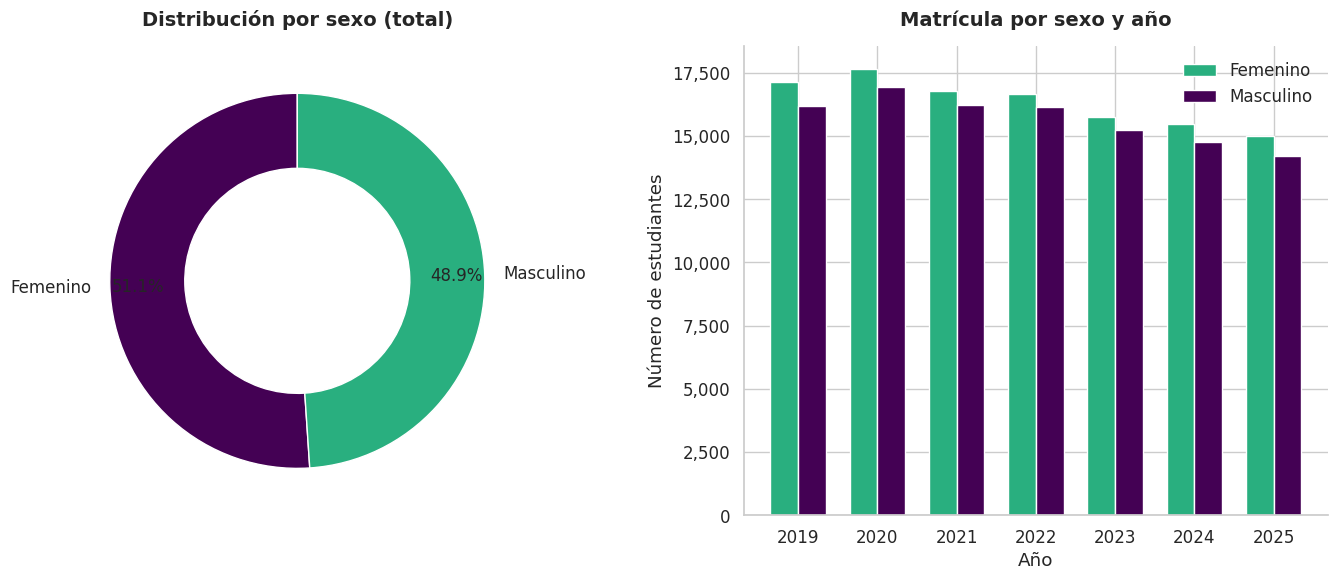


Tabla resumen - Sexo por año:


,F (n),F (%),M (n),M (%)
Año,,,,
2019,"17,136",51.4%,"16,209",48.6%
2020,"17,664",51.0%,"16,950",49.0%
2021,"16,802",50.8%,"16,246",49.2%
2022,"16,678",50.8%,"16,147",49.2%
2023,"15,770",50.9%,"15,224",49.1%
2024,"15,463",51.1%,"14,777",48.9%
2025,"15,013",51.4%,"14,221",48.6%


In [10]:
# --- Gráfico de torta general ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Torta
genero_conteo = SIMAT['GENERO'].value_counts()
colores_genero = [palette[0], palette[12]]
axes[0].pie(genero_conteo, labels=genero_conteo.index.map({'M': 'Masculino', 'F': 'Femenino'}),
            autopct='%1.1f%%', colors=colores_genero, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Distribución por sexo (total)', fontsize=14, fontweight='bold', pad=15)

# Barras por año
genero_anual = SIMAT.groupby(['ANO_INF', 'GENERO']).size().unstack(fill_value=0)
x = np.arange(len(genero_anual))
w = 0.35
bars1 = axes[1].bar(x - w/2, genero_anual['F'], w, label='Femenino', color=palette[12], edgecolor='white')
bars2 = axes[1].bar(x + w/2, genero_anual['M'], w, label='Masculino', color=palette[0], edgecolor='white')

axes[1].set_title('Matrícula por sexo y año', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Número de estudiantes')
axes[1].set_xticks(x)
axes[1].set_xticklabels(genero_anual.index.astype(str))
axes[1].legend(frameon=False)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Sexo por año:")
display(tabla_resumen(SIMAT, 'GENERO'))

---
## 8. Población Víctima del Conflicto

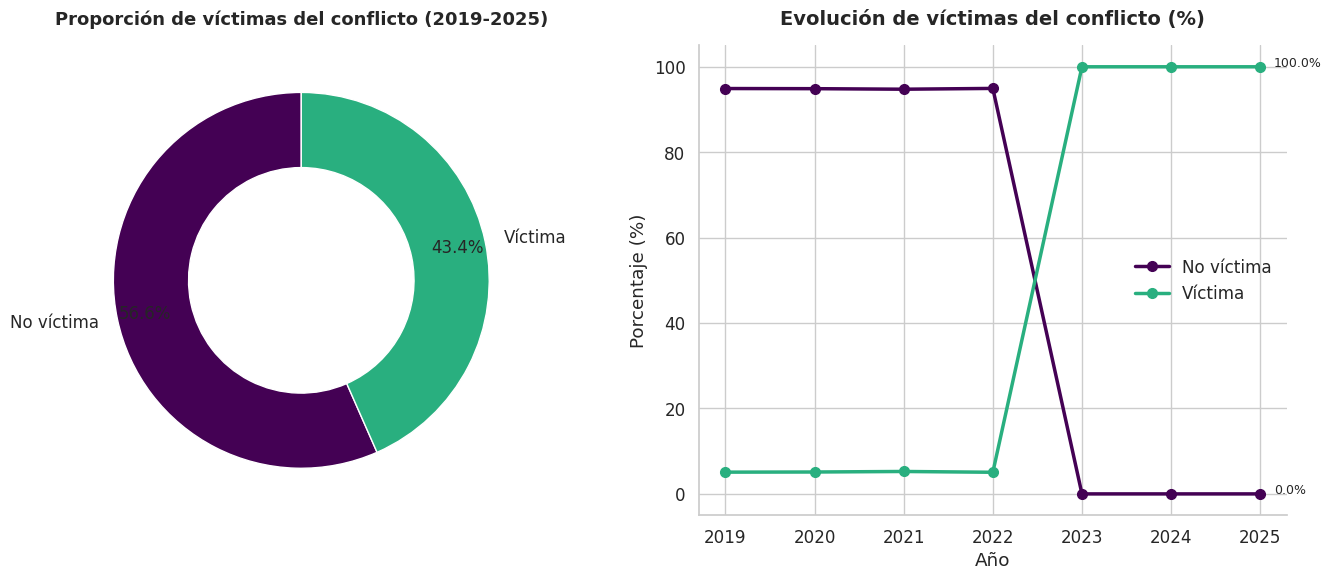


Tabla resumen - Víctimas del conflicto por año:


,No víctima (n),No víctima (%),Víctima (n),Víctima (%)
Año,,,,
2019,"31,647",94.9%,"1,698",5.1%
2020,"32,840",94.9%,"1,774",5.1%
2021,"31,313",94.8%,"1,735",5.2%
2022,"31,163",94.9%,"1,662",5.1%
2023,0,0.0%,"30,994",100.0%
2024,0,0.0%,"30,240",100.0%
2025,0,0.0%,"29,234",100.0%


In [11]:
# ============================================================
# Sección 8: Población Víctima del Conflicto (corregido)
# ============================================================
# Reemplaza el bloque anterior completo

# --- Recodificar variable ---
SIMAT['VICTIMA'] = SIMAT['POBLACION_VICTIMA_CONFLICTO'].map({
    'SI ES POBLACION VICTIMA': 'Víctima',
    'NO ES POBLACION VICTIMA': 'No víctima'
}).fillna('Sin dato')

# --- Distribución general + Evolución temporal ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Torta
victima_conteo = SIMAT['VICTIMA'].value_counts()
victima_conteo = victima_conteo[victima_conteo.index != 'Sin dato']
n_cats_v = len(victima_conteo)
colores_victima = [palette[0], palette[12]][:n_cats_v]

axes[0].pie(victima_conteo, labels=victima_conteo.index,
            autopct='%1.1f%%', colors=colores_victima, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Proporción de víctimas del conflicto (2019-2025)',
                  fontsize=13, fontweight='bold', pad=15)

# Evolución temporal
victima_anual = SIMAT[SIMAT['VICTIMA'] != 'Sin dato'].groupby(['ANO_INF', 'VICTIMA']).size().unstack(fill_value=0)
victima_pct = victima_anual.div(victima_anual.sum(axis=1), axis=0) * 100

for i, col in enumerate(victima_pct.columns):
    axes[1].plot(victima_pct.index, victima_pct[col], marker='o', linewidth=2.5,
                 markersize=7, label=col, color=colores_victima[i])
    ultimo = victima_pct[col].iloc[-1]
    axes[1].annotate(f'{ultimo:.1f}%', (victima_pct.index[-1], ultimo),
                     textcoords='offset points', xytext=(10, 0), fontsize=9)

axes[1].set_title('Evolución de víctimas del conflicto (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].legend(frameon=False)
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

print("\nTabla resumen - Víctimas del conflicto por año:")
display(tabla_resumen(SIMAT[SIMAT['VICTIMA'] != 'Sin dato'], 'VICTIMA'))

---
## 9. Discapacidad

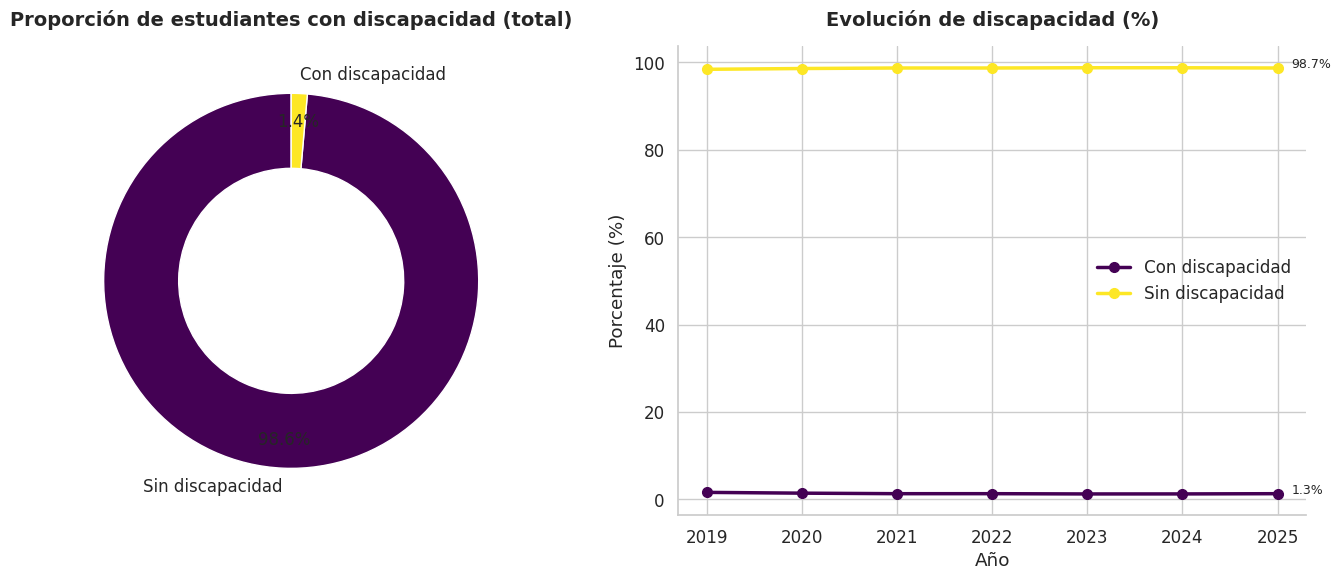


Tabla resumen - Discapacidad por año:


,Con discapacidad (n),Con discapacidad (%),Sin discapacidad (n),Sin discapacidad (%)
Año,,,,
2019,543,1.6%,"32,802",98.4%
2020,502,1.5%,"34,112",98.5%
2021,439,1.3%,"32,609",98.7%
2022,437,1.3%,"32,388",98.7%
2023,394,1.3%,"30,600",98.7%
2024,386,1.3%,"29,854",98.7%
2025,389,1.3%,"28,845",98.7%


In [12]:
# --- Distribución general y evolución temporal ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disc_conteo = SIMAT['DISCAPACIDAD'].value_counts()
n_cats_d = len(disc_conteo)
colores_disc = [palette[int(i * (len(palette)-1) / max(n_cats_d-1, 1))] for i in range(n_cats_d)]
axes[0].pie(disc_conteo, labels=disc_conteo.index,
            autopct='%1.1f%%', colors=colores_disc, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Proporción de estudiantes con discapacidad (total)', fontsize=14, fontweight='bold', pad=15)

disc_anual = SIMAT.groupby(['ANO_INF', 'DISCAPACIDAD']).size().unstack(fill_value=0)
disc_pct = disc_anual.div(disc_anual.sum(axis=1), axis=0) * 100

n_cats_dt = len(disc_pct.columns)
colores_disc_t = [palette[int(i * (len(palette)-1) / max(n_cats_dt-1, 1))] for i in range(n_cats_dt)]

for i, col in enumerate(disc_pct.columns):
    axes[1].plot(disc_pct.index, disc_pct[col], marker='o', linewidth=2.5,
                 markersize=7, label=col, color=colores_disc_t[i])
    ultimo = disc_pct[col].iloc[-1]
    axes[1].annotate(f'{ultimo:.1f}%', (disc_pct.index[-1], ultimo),
                     textcoords='offset points', xytext=(10, 0), fontsize=9)

axes[1].set_title('Evolución de discapacidad (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].legend(frameon=False)
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

print("\nTabla resumen - Discapacidad por año:")
display(tabla_resumen(SIMAT, 'DISCAPACIDAD'))

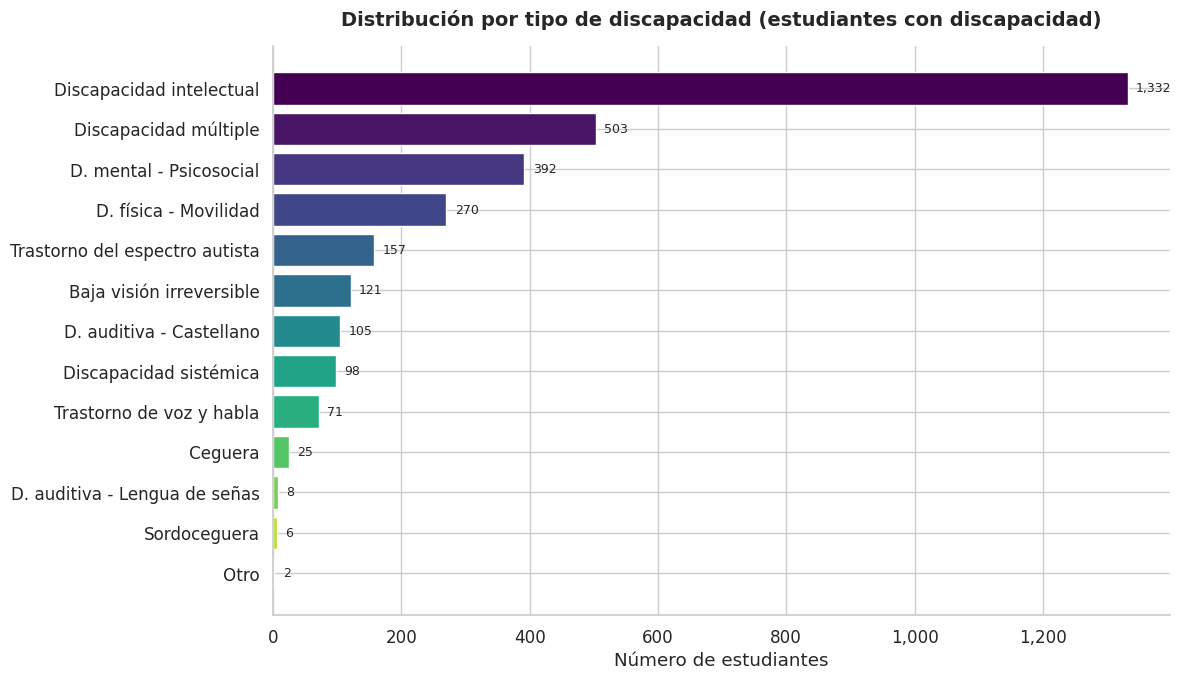


Distribución por tipo de discapacidad y año:


,Baja visión irreversible (n),Baja visión irreversible (%),Ceguera (n),Ceguera (%),D. auditiva - Castellano (n),D. auditiva - Castellano (%),D. auditiva - Lengua de señas (n),D. auditiva - Lengua de señas (%),D. física - Movilidad (n),D. física - Movilidad (%),...,Discapacidad sistémica (n),Discapacidad sistémica (%),Otro (n),Otro (%),Sordoceguera (n),Sordoceguera (%),Trastorno de voz y habla (n),Trastorno de voz y habla (%),Trastorno del espectro autista (n),Trastorno del espectro autista (%)
Año,,,,,,,,,,,,,,,,,,,,,
2019,27,5.0%,3,0.6%,12,2.2%,1,0.2%,42,7.7%,...,60,11.0%,0,0.0%,0,0.0%,36,6.6%,10,1.8%
2020,19,3.8%,9,1.8%,11,2.2%,2,0.4%,46,9.2%,...,23,4.6%,2,0.4%,1,0.2%,16,3.2%,9,1.8%
2021,16,3.6%,6,1.4%,14,3.2%,2,0.5%,41,9.3%,...,8,1.8%,0,0.0%,1,0.2%,6,1.4%,11,2.5%
2022,16,3.7%,4,0.9%,18,4.1%,2,0.5%,42,9.6%,...,6,1.4%,0,0.0%,2,0.5%,5,1.1%,20,4.6%
2023,16,4.1%,1,0.3%,18,4.6%,0,0.0%,36,9.1%,...,1,0.3%,0,0.0%,2,0.5%,5,1.3%,30,7.6%
2024,11,2.8%,1,0.3%,19,4.9%,0,0.0%,31,8.0%,...,0,0.0%,0,0.0%,0,0.0%,3,0.8%,33,8.5%
2025,16,4.1%,1,0.3%,13,3.3%,1,0.3%,32,8.2%,...,0,0.0%,0,0.0%,0,0.0%,0,0.0%,44,11.3%


In [13]:
# --- Distribución por tipo de discapacidad (solo estudiantes con discapacidad) ---
# Diccionario de tipos de discapacidad
dict_discapacidad = {
    3: 'Baja visión irreversible',
    4: 'Ceguera',
    7: 'Trastorno del espectro autista',
    8: 'Discapacidad intelectual',
    10: 'Discapacidad múltiple',
    12: 'D. auditiva - Lengua de señas',
    13: 'D. auditiva - Castellano',
    14: 'Sordoceguera',
    15: 'D. física - Movilidad',
    17: 'Discapacidad sistémica',
    18: 'D. mental - Psicosocial',
    19: 'Trastorno de voz y habla',
}

# Filtrar solo estudiantes con discapacidad
df_disc = SIMAT[SIMAT['TIPO_DISCAPACIDAD'] != 99].copy()
df_disc['TIPO_DISC_NOMBRE'] = df_disc['TIPO_DISCAPACIDAD'].map(dict_discapacidad).fillna('Otro')

# Conteo general
conteo_tipo = df_disc['TIPO_DISC_NOMBRE'].value_counts()

fig, ax = plt.subplots(figsize=(12, 7))
n_barras = len(conteo_tipo)
colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]
bars = ax.barh(conteo_tipo.index[::-1], conteo_tipo.values[::-1], color=colores[::-1], edgecolor='white')

for bar, val in zip(bars, conteo_tipo.values[::-1]):
    ax.text(val + conteo_tipo.max()*0.01, bar.get_y() + bar.get_height()/2,
            f'{int(val):,}', va='center', fontsize=9)

ax.set_title('Distribución por tipo de discapacidad (estudiantes con discapacidad)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Número de estudiantes')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen por tipo de discapacidad y año
print('\nDistribución por tipo de discapacidad y año:')
display(tabla_resumen(df_disc, 'TIPO_DISC_NOMBRE'))

---
## 10. Distribución Étnica

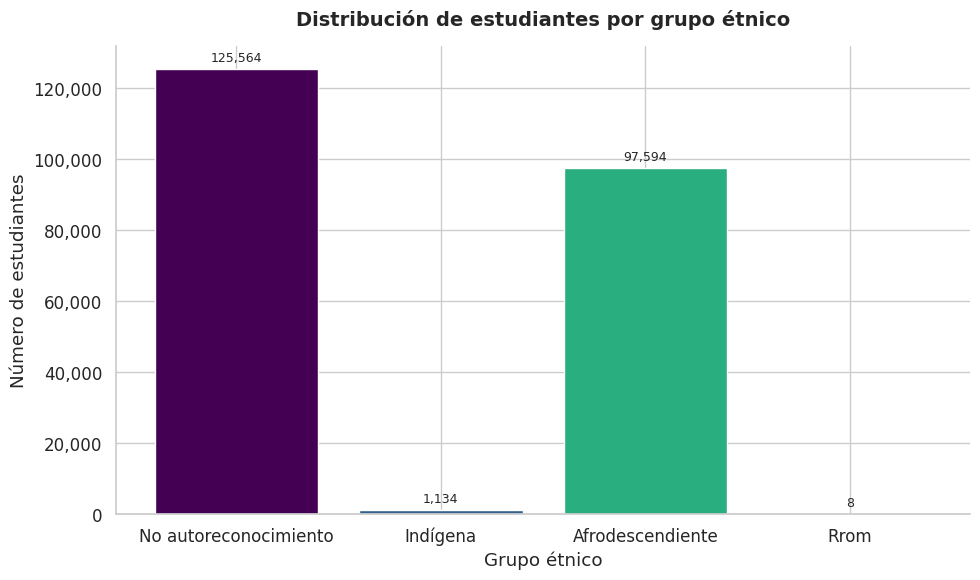


Tabla resumen - Etnia por año:


,Afrodescendiente (n),Afrodescendiente (%),Indígena (n),Indígena (%),No autoreconocimiento (n),No autoreconocimiento (%),Rrom (n),Rrom (%)
Año,,,,,,,,
2019,"16,884",50.6%,221,0.7%,"16,237",48.7%,3,0.0%
2020,"15,591",45.0%,183,0.5%,"18,838",54.4%,2,0.0%
2021,"14,191",42.9%,161,0.5%,"18,695",56.6%,1,0.0%
2022,"13,188",40.2%,156,0.5%,"19,480",59.3%,1,0.0%
2023,"12,443",40.1%,151,0.5%,"18,399",59.4%,1,0.0%
2024,"12,943",42.8%,127,0.4%,"17,170",56.8%,0,0.0%
2025,"12,354",42.3%,135,0.5%,"16,745",57.3%,0,0.0%


In [14]:
orden_etnia = ['No autoreconocimiento', 'Indígena', 'Afrodescendiente', 'Rrom']

# --- Distribución general ---
fig, ax = plt.subplots(figsize=(10, 6))
grafico_barras(SIMAT, 'ETNIA_CAT', 'Distribución de estudiantes por grupo étnico',
               'Grupo étnico', orden=orden_etnia, ax=ax)
plt.show()

# --- Tabla resumen ---
print("\nTabla resumen - Etnia por año:")
display(tabla_resumen(SIMAT, 'ETNIA_CAT'))

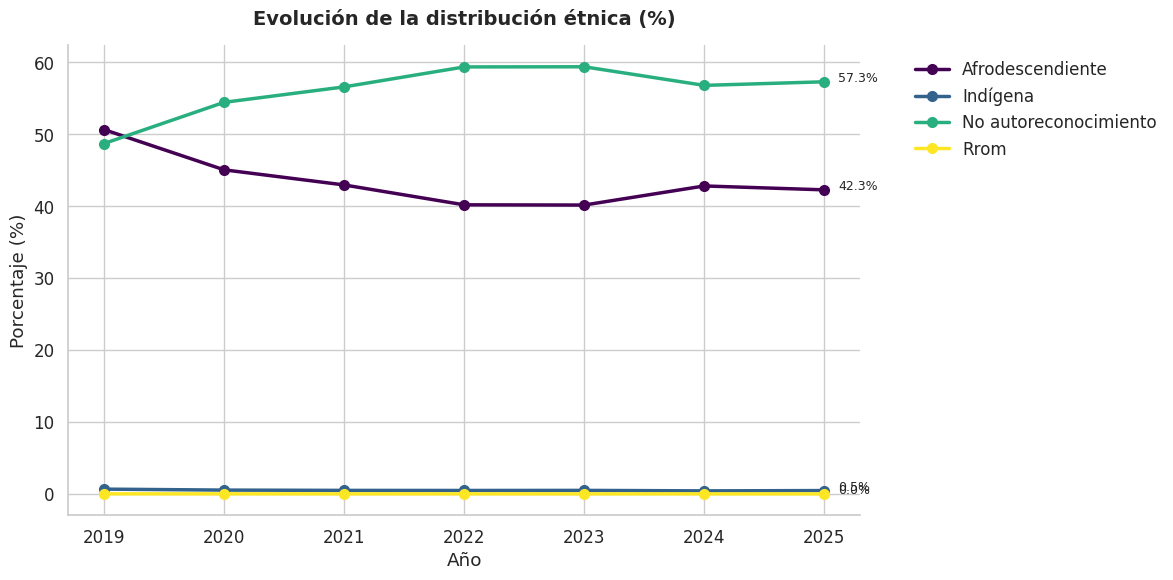

In [15]:
# --- Evolución temporal (porcentaje) ---
grafico_lineas_temporal(SIMAT, 'ETNIA_CAT',
                        'Evolución de la distribución étnica (%)',
                        porcentaje=True)

---
## 11. Distribución por Grado y Nivel Educativo

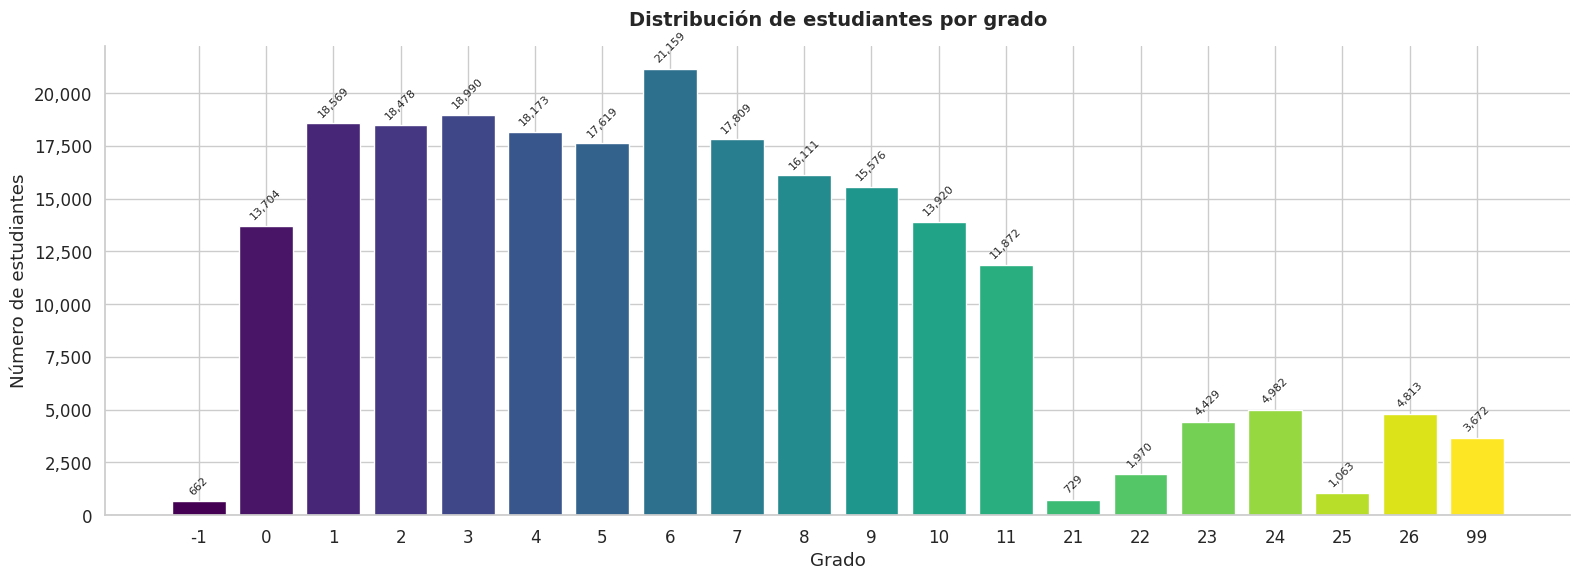

In [16]:
# --- Distribución por grado ---
grados_orden = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 22, 23, 24, 25, 26, 99]
grado_conteo = SIMAT['GRADO'].value_counts().reindex(grados_orden).dropna()

fig, ax = plt.subplots(figsize=(16, 6))
n_barras = len(grado_conteo)
colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]
bars = ax.bar(grado_conteo.index.astype(str), grado_conteo.values, color=colores, edgecolor='white')

for bar, val in zip(bars, grado_conteo.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + grado_conteo.max()*0.01,
            f'{int(val):,}', ha='center', va='bottom', fontsize=8, rotation=45)

ax.set_title('Distribución de estudiantes por grado', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Grado')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

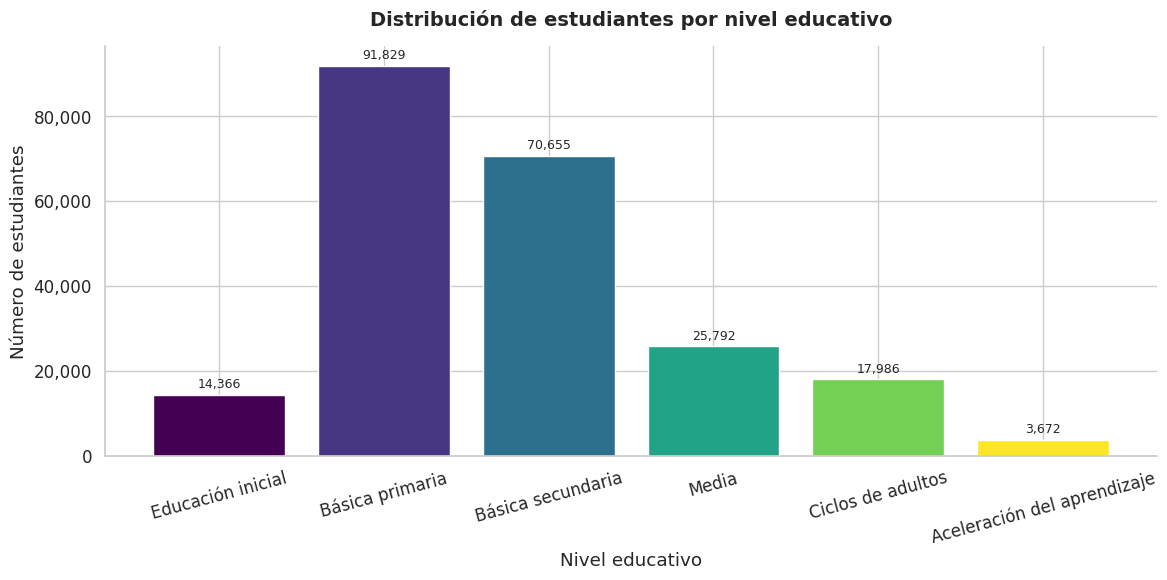


Tabla resumen - Nivel educativo por año:


,Aceleración del aprendizaje (n),Aceleración del aprendizaje (%),Básica primaria (n),Básica primaria (%),Básica secundaria (n),Básica secundaria (%),Ciclos de adultos (n),Ciclos de adultos (%),Educación inicial (n),Educación inicial (%),Media (n),Media (%)
Año,,,,,,,,,,,,
2019,659,2.0%,"13,319",39.9%,"10,888",32.7%,"2,885",8.7%,"1,929",5.8%,"3,665",11.0%
2020,646,1.9%,"13,604",39.3%,"11,158",32.2%,"3,145",9.1%,"2,093",6.0%,"3,968",11.5%
2021,529,1.6%,"13,350",40.4%,"10,791",32.7%,"2,374",7.2%,"2,019",6.1%,"3,985",12.1%
2022,567,1.7%,"13,133",40.0%,"10,270",31.3%,"2,740",8.3%,"2,320",7.1%,"3,795",11.6%
2023,545,1.8%,"12,870",41.5%,"9,464",30.5%,"2,384",7.7%,"2,091",6.7%,"3,640",11.7%
2024,386,1.3%,"12,871",42.6%,"9,140",30.2%,"2,369",7.8%,"2,050",6.8%,"3,424",11.3%
2025,340,1.2%,"12,682",43.4%,"8,944",30.6%,"2,089",7.1%,"1,864",6.4%,"3,315",11.3%


In [17]:
# --- Distribución por nivel educativo ---
orden_nivel = ['Educación inicial', 'Básica primaria', 'Básica secundaria', 'Media',
               'Ciclos de adultos', 'Aceleración del aprendizaje']

fig, ax = plt.subplots(figsize=(12, 6))
grafico_barras(SIMAT, 'NIVEL_EDUCATIVO', 'Distribución de estudiantes por nivel educativo',
               'Nivel educativo', orden=orden_nivel, ax=ax, rotation=15)
plt.show()

# --- Tabla resumen ---
print("\nTabla resumen - Nivel educativo por año:")
display(tabla_resumen(SIMAT, 'NIVEL_EDUCATIVO'))

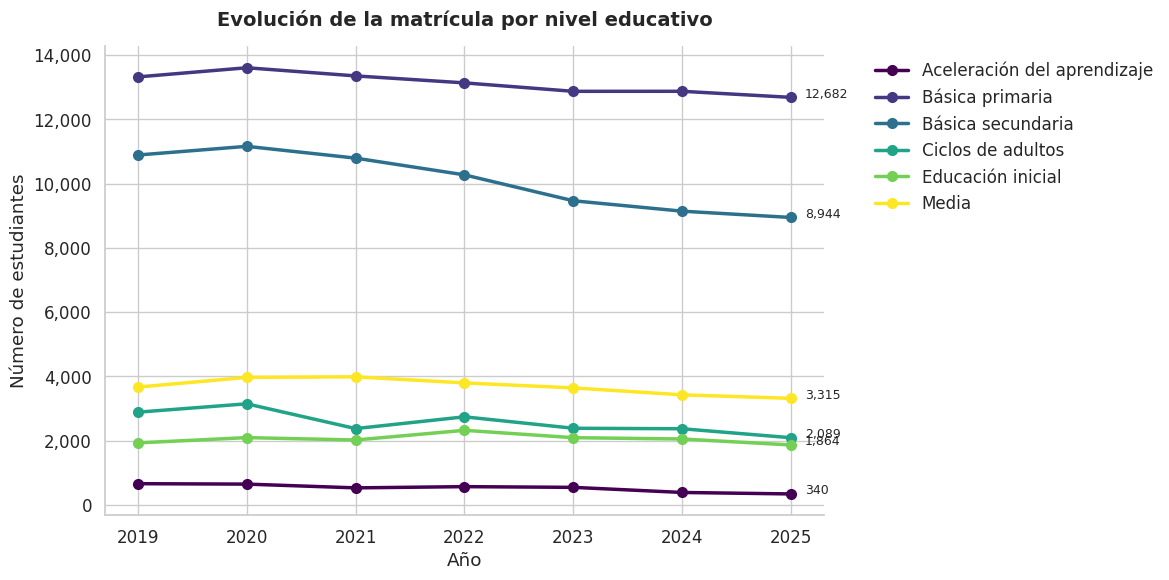

In [18]:
# --- Evolución temporal por nivel educativo ---
grafico_lineas_temporal(SIMAT, 'NIVEL_EDUCATIVO',
                        'Evolución de la matrícula por nivel educativo',
                        porcentaje=False)

---
## 12. Cabeza de Familia y Beneficiario Madre Cabeza de Familia

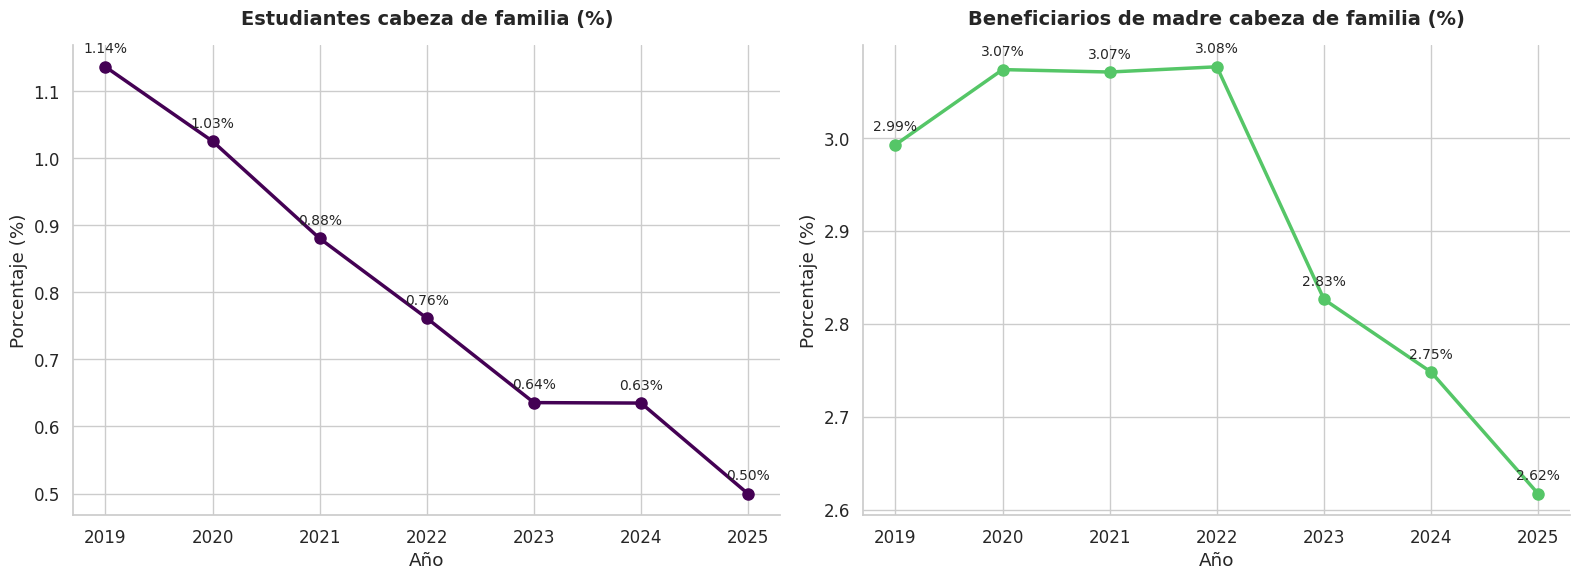


Tabla resumen - Cabeza de familia por año:


,N (n),N (%),S (n),S (%)
Año,,,,
2019,"32,966",98.9%,379,1.1%
2020,"34,259",99.0%,355,1.0%
2021,"32,757",99.1%,291,0.9%
2022,"32,575",99.2%,250,0.8%
2023,"30,797",99.4%,197,0.6%
2024,"30,048",99.4%,192,0.6%
2025,"29,088",99.5%,146,0.5%



Tabla resumen - Beneficiario madre cabeza de familia por año:


,N (n),N (%),S (n),S (%)
Año,,,,
2019,"32,347",97.0%,998,3.0%
2020,"33,550",96.9%,"1,064",3.1%
2021,"32,033",96.9%,"1,015",3.1%
2022,"31,815",96.9%,"1,010",3.1%
2023,"30,118",97.2%,876,2.8%
2024,"29,409",97.3%,831,2.7%
2025,"28,469",97.4%,765,2.6%


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Cabeza de familia ---
cab_anual = SIMAT.groupby('ANO_INF').apply(
    lambda df: (df['CAB_FAMILIA'] == 'S').sum() / len(df) * 100
).reset_index(name='Porcentaje')

axes[0].plot(cab_anual['ANO_INF'], cab_anual['Porcentaje'], marker='o', linewidth=2.5,
             markersize=8, color=palette[0])
for _, row in cab_anual.iterrows():
    axes[0].annotate(f'{row["Porcentaje"]:.2f}%', (row['ANO_INF'], row['Porcentaje']),
                     textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10)

axes[0].set_title('Estudiantes cabeza de familia (%)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Porcentaje (%)')
axes[0].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[0].spines[['top', 'right']].set_visible(False)

# --- Beneficiario madre cabeza de familia ---
ben_anual = SIMAT.groupby('ANO_INF').apply(
    lambda df: (df['BEN_MAD_FLIA'] == 'S').sum() / len(df) * 100
).reset_index(name='Porcentaje')

axes[1].plot(ben_anual['ANO_INF'], ben_anual['Porcentaje'], marker='o', linewidth=2.5,
             markersize=8, color=palette[14])
for _, row in ben_anual.iterrows():
    axes[1].annotate(f'{row["Porcentaje"]:.2f}%', (row['ANO_INF'], row['Porcentaje']),
                     textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10)

axes[1].set_title('Beneficiarios de madre cabeza de familia (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# Tablas resumen
print("\nTabla resumen - Cabeza de familia por año:")
display(tabla_resumen(SIMAT, 'CAB_FAMILIA'))
print("\nTabla resumen - Beneficiario madre cabeza de familia por año:")
display(tabla_resumen(SIMAT, 'BEN_MAD_FLIA'))

---
## 13. Índices de Eficiencia Educativa

Los índices de eficiencia educativa se componen de:
- **Índice de deserción**: Desertores (SIMPADE) / Matrícula (SIMAT) × 100
- **Índice de repitencia**: Repitentes / Matrícula × 100
- **Índice de aprobación**: 100% - Deserción - Repitencia

Se calculan desde 2020 en adelante (disponibilidad de SIMPADE).

Índices de eficiencia educativa calculados:


,ANO,MATRICULA,DESERTORES,REPITENTES,IND_DESERCION,IND_REPITENCIA,IND_APROBACION
0,2020,34614,501,2813,1.45,8.13,90.42
1,2021,33048,1344,2740,4.07,8.29,87.64
2,2022,32825,1816,3069,5.53,9.35,85.12
3,2023,30994,1968,4020,6.35,12.97,80.68
4,2024,30240,1981,4755,6.55,15.72,77.73
5,2025,29234,1776,3491,6.08,11.94,81.98


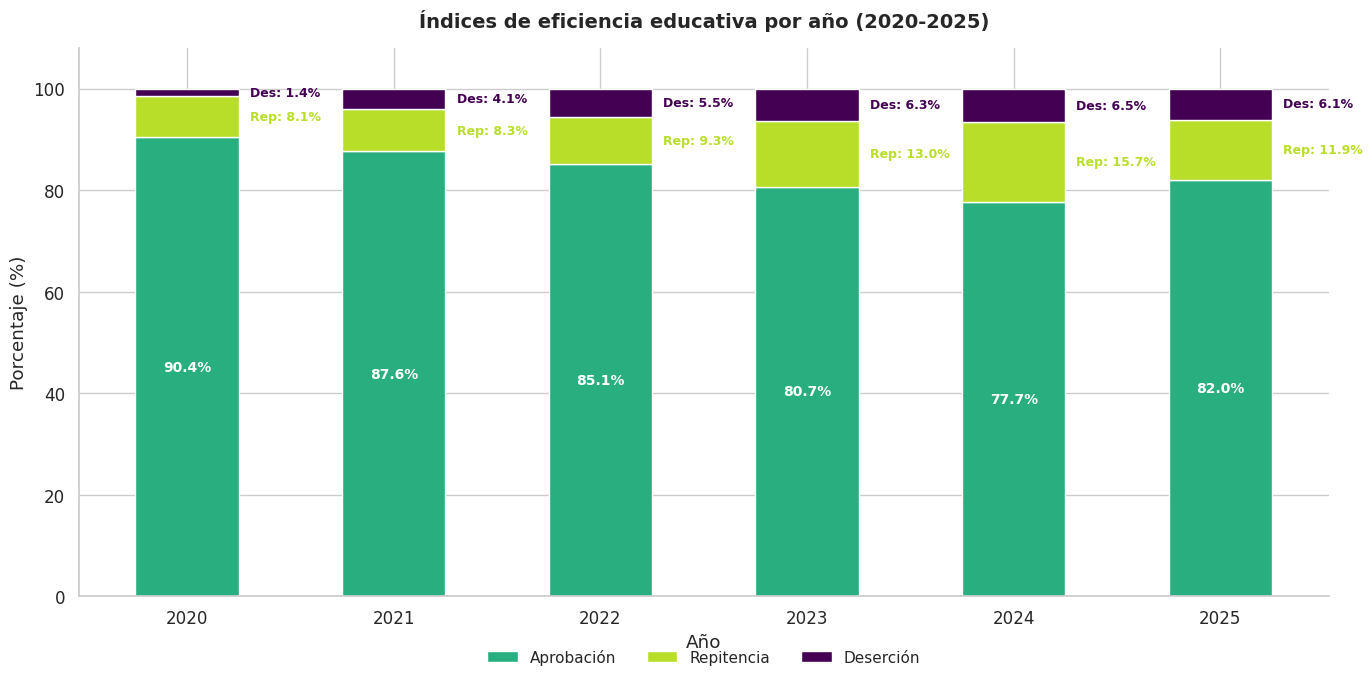

In [20]:
# ============================================================
# Cálculo de los tres índices de eficiencia educativa
# ============================================================

# --- Deserción: SIMPADE / SIMAT (por año, desde 2020) ---
simat_2020 = SIMAT[SIMAT['ANO_INF'] >= 2020].copy()

matricula_sede = simat_2020.groupby(['DANE_ANTERIOR', 'ANO_INF']).size().reset_index(name='MATRICULA')
matricula_sede.columns = ['DANE_SEDE', 'ANO', 'MATRICULA']

desercion_sede = SIMPADE.groupby(['SPD_DANE_SEDE', 'ANNO_INF']).size().reset_index(name='DESERTORES')
desercion_sede.columns = ['DANE_SEDE', 'ANO', 'DESERTORES']

indices = matricula_sede.groupby('ANO').agg(MATRICULA=('MATRICULA', 'sum')).reset_index()
des_anual = desercion_sede.groupby('ANO').agg(DESERTORES=('DESERTORES', 'sum')).reset_index()
indices = indices.merge(des_anual, on='ANO', how='left')
indices['DESERTORES'] = indices['DESERTORES'].fillna(0).astype(int)

# --- Repitencia por año (desde 2020) ---
rep_anual = simat_2020.groupby('ANO_INF').apply(
    lambda df: (df['REPITENTE'] == 'S').sum()
).reset_index(name='REPITENTES')
rep_anual.columns = ['ANO', 'REPITENTES']
indices = indices.merge(rep_anual, on='ANO', how='left')

# --- Cálculo de índices ---
indices['IND_DESERCION'] = (indices['DESERTORES'] / indices['MATRICULA'] * 100).round(2)
indices['IND_REPITENCIA'] = (indices['REPITENTES'] / indices['MATRICULA'] * 100).round(2)
indices['IND_APROBACION'] = (100 - indices['IND_DESERCION'] - indices['IND_REPITENCIA']).round(2)

print('Índices de eficiencia educativa calculados:')
display(indices)

# ============================================================
# Visualización: Barras apiladas
# ============================================================
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(indices))
w = 0.5

c_aprobacion = palette[12]   # verde
c_repitencia = palette[17]   # amarillo
c_desercion = palette[0]     # morado oscuro

bars1 = ax.bar(x, indices['IND_APROBACION'], w, label='Aprobación', color=c_aprobacion, edgecolor='white')
bars2 = ax.bar(x, indices['IND_REPITENCIA'], w, bottom=indices['IND_APROBACION'],
               label='Repitencia', color=c_repitencia, edgecolor='white')
bars3 = ax.bar(x, indices['IND_DESERCION'], w,
               bottom=indices['IND_APROBACION'] + indices['IND_REPITENCIA'],
               label='Deserción', color=c_desercion, edgecolor='white')

for i in range(len(indices)):
    # Aprobación centrada
    y_ap = indices['IND_APROBACION'].iloc[i] / 2
    ax.text(x[i], y_ap, f"{indices['IND_APROBACION'].iloc[i]:.1f}%",
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # Repitencia a la derecha
    y_rep = indices['IND_APROBACION'].iloc[i] + indices['IND_REPITENCIA'].iloc[i] / 2
    ax.annotate(f"Rep: {indices['IND_REPITENCIA'].iloc[i]:.1f}%",
                xy=(x[i] + w/2, y_rep), xytext=(8, 0),
                textcoords='offset points', ha='left', va='center', fontsize=9,
                color=c_repitencia, fontweight='bold')
    # Deserción a la derecha
    y_des = indices['IND_APROBACION'].iloc[i] + indices['IND_REPITENCIA'].iloc[i] + indices['IND_DESERCION'].iloc[i] / 2
    ax.annotate(f"Des: {indices['IND_DESERCION'].iloc[i]:.1f}%",
                xy=(x[i] + w/2, y_des), xytext=(8, 0),
                textcoords='offset points', ha='left', va='center', fontsize=9,
                color=c_desercion, fontweight='bold')

ax.set_title('Índices de eficiencia educativa por año (2020-2025)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(x)
ax.set_xticklabels(indices['ANO'].astype(str))
ax.set_ylim(0, 108)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

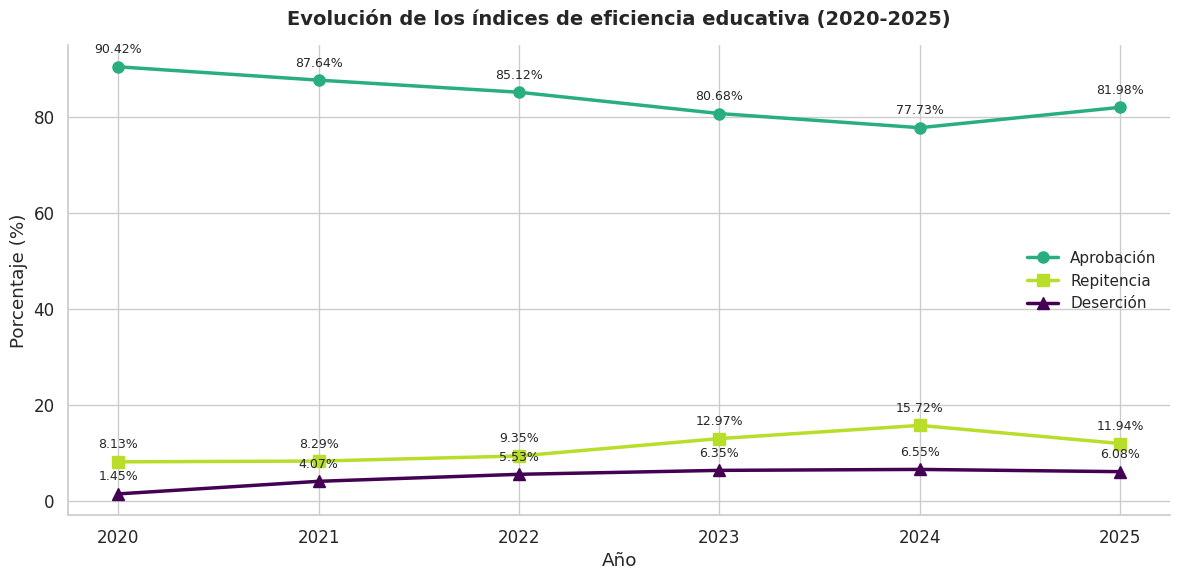


Tabla resumen - Índices de eficiencia educativa:


,Matrícula,Desertores,Repitentes,Índice deserción,Índice repitencia,Índice aprobación
ANO,,,,,,
2020,"34,614",501,"2,813",1.45%,8.13%,90.42%
2021,"33,048","1,344","2,740",4.07%,8.29%,87.64%
2022,"32,825","1,816","3,069",5.53%,9.35%,85.12%
2023,"30,994","1,968","4,020",6.35%,12.97%,80.68%
2024,"30,240","1,981","4,755",6.55%,15.72%,77.73%
2025,"29,234","1,776","3,491",6.08%,11.94%,81.98%


In [21]:
# ============================================================
# Evolución de cada índice (gráfico de líneas)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(indices['ANO'], indices['IND_APROBACION'], marker='o', linewidth=2.5,
        markersize=8, label='Aprobación', color=palette[12])
ax.plot(indices['ANO'], indices['IND_REPITENCIA'], marker='s', linewidth=2.5,
        markersize=8, label='Repitencia', color=palette[17])
ax.plot(indices['ANO'], indices['IND_DESERCION'], marker='^', linewidth=2.5,
        markersize=8, label='Deserción', color=palette[0])

for col, offset in [('IND_APROBACION', 1.5), ('IND_REPITENCIA', -1.5), ('IND_DESERCION', -1.5)]:
    for _, row in indices.iterrows():
        ax.annotate(f"{row[col]:.2f}%", (row['ANO'], row[col]),
                    textcoords='offset points', xytext=(0, 10), ha='center', fontsize=9)

ax.set_title('Evolución de los índices de eficiencia educativa (2020-2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(indices['ANO'])
ax.legend(frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print('\nTabla resumen - Índices de eficiencia educativa:')
tabla_ef = indices.set_index('ANO').copy()
tabla_ef['MATRICULA'] = tabla_ef['MATRICULA'].apply(lambda x: f'{int(x):,}')
tabla_ef['DESERTORES'] = tabla_ef['DESERTORES'].apply(lambda x: f'{int(x):,}')
tabla_ef['REPITENTES'] = tabla_ef['REPITENTES'].apply(lambda x: f'{int(x):,}')
tabla_ef['IND_DESERCION'] = tabla_ef['IND_DESERCION'].apply(lambda x: f'{x:.2f}%')
tabla_ef['IND_REPITENCIA'] = tabla_ef['IND_REPITENCIA'].apply(lambda x: f'{x:.2f}%')
tabla_ef['IND_APROBACION'] = tabla_ef['IND_APROBACION'].apply(lambda x: f'{x:.2f}%')
tabla_ef.columns = ['Matrícula', 'Desertores', 'Repitentes',
                     'Índice deserción', 'Índice repitencia', 'Índice aprobación']
display(tabla_ef)

---
## 14. Resumen general

In [22]:
# Resumen consolidado del último año disponible
ultimo_ano = SIMAT['ANO_INF'].max()
df_ultimo = SIMAT[SIMAT['ANO_INF'] == ultimo_ano]

print(f"{'='*60}")
print(f"RESUMEN DEL AÑO {ultimo_ano}")
print(f"{'='*60}")
print(f"Total matrícula: {len(df_ultimo):,}")
print(f"\n--- Género ---")
for g, n in df_ultimo['GENERO'].value_counts().items():
    label = 'Femenino' if g == 'F' else 'Masculino'
    print(f"  {label}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Edad ---")
edades = df_ultimo['EDAD'].dropna()
print(f"  Media: {edades.mean():.1f} años | Mediana: {edades.median():.0f} años")

print(f"\n--- Estrato ---")
for e in ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']:
    n = (df_ultimo['ESTRATO_CAT'] == e).sum()
    if n > 0:
        print(f"  {e}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Víctimas del conflicto ---")
n_vict = (df_ultimo['VICTIMA'] == 'Víctima').sum()
print(f"  Víctimas: {n_vict:,} ({n_vict/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Discapacidad ---")
n_disc = (df_ultimo['DISCAPACIDAD'] == 'Con discapacidad').sum()
print(f"  Con discapacidad: {n_disc:,} ({n_disc/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Etnia ---")
for e in ['No autoreconocimiento', 'Indígena', 'Afrodescendiente', 'Rrom']:
    n = (df_ultimo['ETNIA_CAT'] == e).sum()
    print(f"  {e}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Repitencia ---")
n_rep = (df_ultimo['REPITENTE'] == 'S').sum()
print(f"  Repitentes: {n_rep:,} ({n_rep/len(df_ultimo)*100:.2f}%)")

print(f"\n--- Cabeza de familia ---")
n_cab = (df_ultimo['CAB_FAMILIA'] == 'S').sum()
print(f"  Cabeza de familia: {n_cab:,} ({n_cab/len(df_ultimo)*100:.2f}%)")

n_ben = (df_ultimo['BEN_MAD_FLIA'] == 'S').sum()
print(f"  Beneficiario madre cabeza de familia: {n_ben:,} ({n_ben/len(df_ultimo)*100:.2f}%)")

RESUMEN DEL AÑO 2025
Total matrícula: 29,234

--- Género ---
  Femenino: 15,013 (51.4%)
  Masculino: 14,221 (48.6%)

--- Edad ---
  Media: 12.8 años | Mediana: 12 años

--- Estrato ---
  No aplica: 1,435 (4.9%)
  Estrato 1: 13,144 (45.0%)
  Estrato 2: 12,217 (41.8%)
  Estrato 3: 2,355 (8.1%)
  Estrato 4: 68 (0.2%)
  Estrato 5: 13 (0.0%)
  Estrato 6: 2 (0.0%)

--- Víctimas del conflicto ---
  Víctimas: 29,234 (100.0%)

--- Discapacidad ---
  Con discapacidad: 389 (1.3%)

--- Etnia ---
  No autoreconocimiento: 16,745 (57.3%)
  Indígena: 135 (0.5%)
  Afrodescendiente: 12,354 (42.3%)
  Rrom: 0 (0.0%)

--- Repitencia ---
  Repitentes: 3,491 (11.94%)

--- Cabeza de familia ---
  Cabeza de familia: 146 (0.50%)
  Beneficiario madre cabeza de familia: 765 (2.62%)


In [23]:
# ============================================================
# Tabla de deserción por sede y año (para mapa de calor)
# ============================================================

# Recuento matrícula por sede y año (desde 2020)
simat_2020 = SIMAT[SIMAT['ANO_INF'] >= 2020].copy()

matricula_sede = simat_2020.groupby(['DANE_ANTERIOR', 'ANO_INF']).size().reset_index(name='MATRICULA')
matricula_sede.columns = ['DANE_SEDE', 'ANO', 'MATRICULA']

# Recuento deserción por sede y año
desercion_sede = SIMPADE.groupby(['SPD_DANE_SEDE', 'ANNO_INF']).size().reset_index(name='DESERTORES')
desercion_sede.columns = ['DANE_SEDE', 'ANO', 'DESERTORES']

# Merge
tabla_sedes = matricula_sede.merge(desercion_sede, on=['DANE_SEDE', 'ANO'], how='left')
tabla_sedes['DESERTORES'] = tabla_sedes['DESERTORES'].fillna(0).astype(int)
tabla_sedes['INDICE_DESERCION'] = (tabla_sedes['DESERTORES'] / tabla_sedes['MATRICULA'] * 100).round(2)

# Agregar nombre de institución y sede
nombres = SIMAT[['DANE_ANTERIOR', 'INSTITUCION', 'SEDE']].drop_duplicates('DANE_ANTERIOR')
nombres.columns = ['DANE_SEDE', 'INSTITUCION', 'SEDE']
tabla_sedes = tabla_sedes.merge(nombres, on='DANE_SEDE', how='left')

# Ordenar columnas
tabla_sedes = tabla_sedes[['DANE_SEDE', 'INSTITUCION', 'SEDE', 'ANO', 'MATRICULA', 'DESERTORES', 'INDICE_DESERCION']]
tabla_sedes = tabla_sedes.sort_values(['DANE_SEDE', 'ANO']).reset_index(drop=True)

print(f"Tabla generada: {tabla_sedes.shape[0]} filas × {tabla_sedes.shape[1]} columnas")
print(f"Sedes: {tabla_sedes['DANE_SEDE'].nunique()} | Años: {sorted(tabla_sedes['ANO'].unique())}")
display(tabla_sedes.head(12))

# Exportar
tabla_sedes.to_excel('/content/drive/MyDrive/reportes 2026/reporte NIKI 2/tabla_desercion_por_sede.xlsx', index=False)
print("\n✅ Archivo exportado: tabla_desercion_por_sede.xlsx")

Tabla generada: 291 filas × 7 columnas
Sedes: 49 | Años: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


,DANE_SEDE,INSTITUCION,SEDE,ANO,MATRICULA,DESERTORES,INDICE_DESERCION
0,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2020,1195,5,0.42
1,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2021,1192,16,1.34
2,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2022,1217,30,2.47
3,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2023,1070,22,2.06
4,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2024,936,71,7.59
5,176001001664,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,INSTITUCION EDUCATIVA VICENTE BORRERO COSTA,2025,838,95,11.34
6,176001002792,INSTITUCION EDUCATIVA TECNICO INDUSTRIAL PEDRO...,JORGE ELIECER GAITAN,2020,1075,40,3.72
7,176001002792,INSTITUCION EDUCATIVA TECNICO INDUSTRIAL PEDRO...,JORGE ELIECER GAITAN,2021,1092,44,4.03
8,176001002792,INSTITUCION EDUCATIVA TECNICO INDUSTRIAL PEDRO...,JORGE ELIECER GAITAN,2022,1066,94,8.82
9,176001002792,INSTITUCION EDUCATIVA TECNICO INDUSTRIAL PEDRO...,JORGE ELIECER GAITAN,2023,818,50,6.11



✅ Archivo exportado: tabla_desercion_por_sede.xlsx


In [24]:
# ============================================================
# Tabla de deserción intraanual (formato para copiar a Word)
# ============================================================
# Formato: una fila por sede, columnas de # y % por cada año

simat_2020 = SIMAT[SIMAT['ANO_INF'] >= 2020].copy()

# Matrícula por sede y año
mat = simat_2020.groupby(['DANE_ANTERIOR', 'ANO_INF']).size().reset_index(name='MATRICULA')
mat.columns = ['DANE_SEDE', 'ANO', 'MATRICULA']

# Deserción por sede y año
des = SIMPADE.groupby(['SPD_DANE_SEDE', 'ANNO_INF']).size().reset_index(name='DESERTORES')
des.columns = ['DANE_SEDE', 'ANO', 'DESERTORES']

# Merge
tabla = mat.merge(des, on=['DANE_SEDE', 'ANO'], how='left')
tabla['DESERTORES'] = tabla['DESERTORES'].fillna(0).astype(int)
tabla['INDICE'] = (tabla['DESERTORES'] / tabla['MATRICULA'] * 100).round(2)

# Nombres de institución y sede
nombres = SIMAT[['DANE_ANTERIOR', 'INSTITUCION', 'SEDE']].drop_duplicates('DANE_ANTERIOR')
nombres.columns = ['DANE_SEDE', 'INSTITUCION', 'SEDE']
tabla = tabla.merge(nombres, on='DANE_SEDE', how='left')

# Pivotar: una fila por sede, columnas # y % por año
años = sorted(tabla['ANO'].unique())

pivot_n = tabla.pivot_table(index=['DANE_SEDE', 'INSTITUCION', 'SEDE'],
                            columns='ANO', values='DESERTORES', fill_value=0)
pivot_pct = tabla.pivot_table(index=['DANE_SEDE', 'INSTITUCION', 'SEDE'],
                              columns='ANO', values='INDICE', fill_value=0)

# Construir tabla final intercalando # y %
resultado = pd.DataFrame()
resultado['IEO'] = pivot_n.reset_index()['INSTITUCION']
resultado['Sede'] = pivot_n.reset_index()['SEDE']

for año in años:
    resultado[f'{año} #'] = pivot_n[año].values
    resultado[f'{año} %'] = pivot_pct[año].values

# Agregar numeración
resultado.insert(0, '#', range(1, len(resultado) + 1))

# Ordenar por IEO y Sede
resultado = resultado.sort_values(['IEO', 'Sede']).reset_index(drop=True)
resultado['#'] = range(1, len(resultado) + 1)

print(f"Tabla generada: {resultado.shape[0]} sedes × {resultado.shape[1]} columnas")
display(resultado)

# Exportar
resultado.to_excel('/content/drive/MyDrive/reportes 2026/reporte NIKI 2/tabla_desercion_intraanual_pivot.xlsx', index=False)
print("\n✅ Exportada: tabla_desercion_intraanual_pivot.xlsx")

Tabla generada: 49 sedes × 15 columnas


,#,IEO,Sede,2020 #,2020 %,2021 #,2021 %,2022 #,2022 %,2023 #,2023 %,2024 #,2024 %,2025 #,2025 %
0,1,I.E. NUEVO LATIR,I.E. NUEVO LATIR - SEDE PRINCIPAL,10.0,0.62,50.0,3.47,47.0,3.54,53.0,3.48,85.0,5.70,47.0,3.16
1,2,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,CENTRAL PROVIVIENDA,0.0,0.00,4.0,1.27,14.0,4.11,5.0,1.47,8.0,2.54,9.0,3.25
2,3,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,1.0,0.21,10.0,2.54,11.0,2.35,18.0,3.99,17.0,3.82,41.0,9.98
3,4,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,LOS FARALLONES,6.0,0.93,18.0,2.32,30.0,4.11,38.0,5.14,37.0,5.15,29.0,3.90
4,5,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,PURIFICACION TRUJILLO,2.0,0.42,7.0,1.51,26.0,5.39,19.0,4.13,20.0,5.31,12.0,3.01
5,6,INSTITUCION EDUCATIVA ALFONSO LOPEZ PUMAREJO,RAFAEL POMBO,4.0,0.78,7.0,1.33,16.0,3.29,24.0,5.06,13.0,2.93,7.0,1.64
6,7,INSTITUCION EDUCATIVA CIUDAD CORDOBA,INSTITUCION EDUCATIVA CIUDAD CORDOBA - SEDE PR...,14.0,0.97,13.0,1.01,62.0,4.67,45.0,4.04,62.0,5.36,40.0,3.46
7,8,INSTITUCION EDUCATIVA CIUDAD CORDOBA,SEDE ENRIQUE OLAYA HERRERA,19.0,1.37,16.0,1.20,32.0,2.38,109.0,9.32,48.0,3.97,59.0,4.86
8,9,INSTITUCION EDUCATIVA CRISTOBAL COLON,BIENESTAR SOCIAL,35.0,7.51,36.0,8.31,36.0,7.79,56.0,11.29,25.0,5.62,13.0,2.78
9,10,INSTITUCION EDUCATIVA EL DIAMANTE,INSTITUCION EDUCATIVA EL DIAMANTE - SEDE PRINC...,18.0,2.03,33.0,3.95,34.0,3.98,49.0,6.31,42.0,5.04,41.0,4.95



✅ Exportada: tabla_desercion_intraanual_pivot.xlsx


In [25]:
# ============================================================
# BLOQUE 1: Carga del SIMAT completo de Cali (2019-2025)
# ============================================================
# Pegar como nueva celda de código

import glob

ruta_base = '/content/drive/MyDrive/reportes 2026/reporte NIKI 2/SIMAT /'

# Cargar 2019 (Excel)
simat_2019 = pd.read_excel(ruta_base + 'Anexo 6a Noviembre 2019.xlsx')
simat_2019['ANO_INF'] = 2019

# Cargar 2020-2025 (Parquet)
frames = [simat_2019]
for año in range(2020, 2026):
    archivo = ruta_base + f'Anexo 6a Noviembre {año}.parquet'
    df_temp = pd.read_parquet(archivo)
    df_temp['ANO_INF'] = año
    frames.append(df_temp)
    print(f"  {año}: {len(df_temp):,} registros")

SIMAT_CALI = pd.concat(frames, ignore_index=True)
print(f"\nSIMAT CALI total: {SIMAT_CALI.shape[0]:,} registros, {SIMAT_CALI.shape[1]} columnas")
print(f"Años: {sorted(SIMAT_CALI['ANO_INF'].unique())}")

# Filtrar solo sector OFICIAL
# (Verificar nombre de columna de sector)
if 'SECTOR' in SIMAT_CALI.columns:
    print(f"\nValores de SECTOR: {SIMAT_CALI['SECTOR'].value_counts().to_dict()}")
    SIMAT_CALI = SIMAT_CALI[SIMAT_CALI['SECTOR'].isin(['OFICIAL', 'Oficial', 'oficial', 1, '1'])].copy()
    print(f"SIMAT CALI (solo oficial): {SIMAT_CALI.shape[0]:,} registros")

# Identificar nuestras 50 sedes
nuestras_sedes = SIMAT['DANE_ANTERIOR'].unique()
SIMAT_CALI['ES_CIEAVC'] = SIMAT_CALI['DANE_ANTERIOR'].isin(nuestras_sedes)

print(f"\nRegistros CIEAVC en SIMAT_CALI: {SIMAT_CALI['ES_CIEAVC'].sum():,}")
print(f"Registros resto: {(~SIMAT_CALI['ES_CIEAVC']).sum():,}")


# ============================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# ============================================================



  2020: 232,627 registros
  2021: 225,470 registros
  2022: 219,266 registros
  2023: 211,011 registros
  2024: 202,575 registros
  2025: 195,679 registros

SIMAT CALI total: 1,516,493 registros, 76 columnas
Años: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Valores de SECTOR: {'OFICIAL': 1105555, 'NO OFICIAL': 405676, 'SGP DEFENSA': 5262}
SIMAT CALI (solo oficial): 1,105,555 registros

Registros CIEAVC en SIMAT_CALI: 224,300
Registros resto: 881,255


Matrícula por año:


,Resto IEO Cali,Sedes CIEAVC,Total
ANO_INF,,,
2019,134399,33345,167744
2020,137709,34614,172323
2021,131581,33048,164629
2022,126871,32825,159696
2023,120863,30994,151857
2024,116949,30240,147189
2025,112883,29234,142117


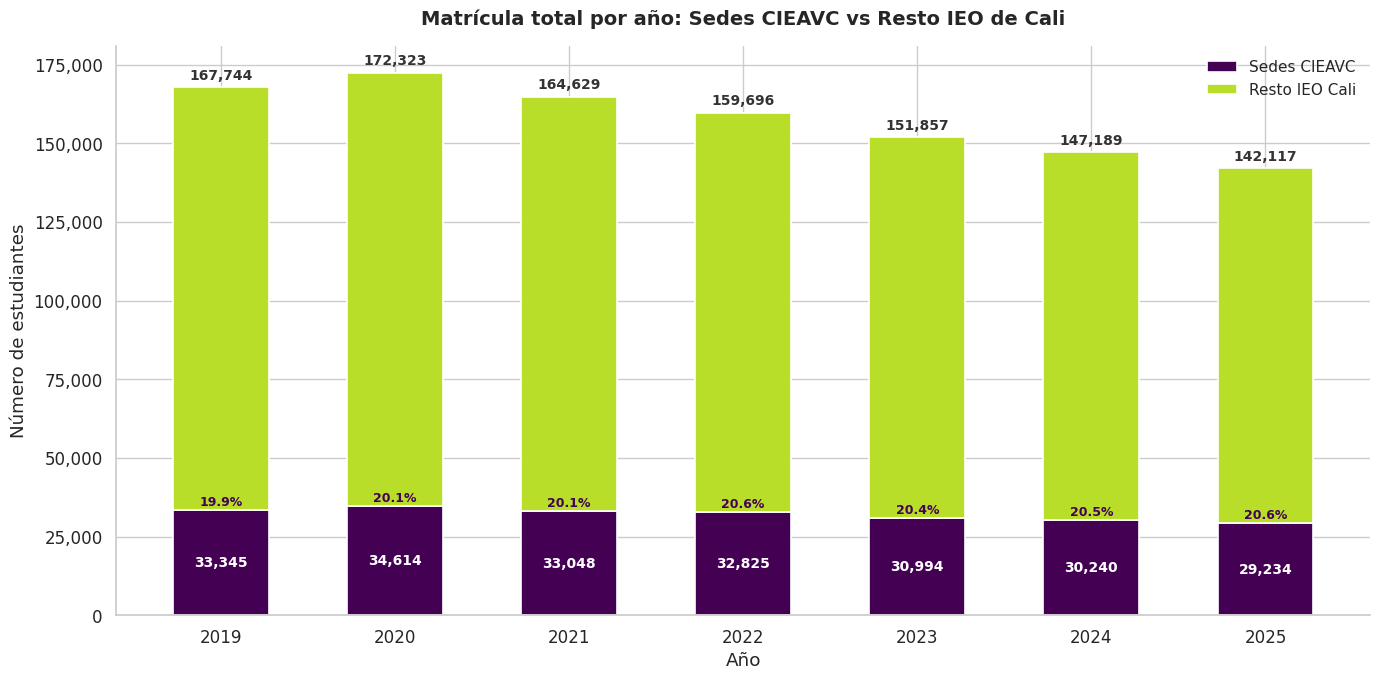


Tabla resumen - Matrícula CIEAVC vs Cali:


,Resto IEO Cali,Sedes CIEAVC,Total,% CIEAVC
ANO_INF,,,,
2019,"134,399","33,345","167,744",19.9%
2020,"137,709","34,614","172,323",20.1%
2021,"131,581","33,048","164,629",20.1%
2022,"126,871","32,825","159,696",20.6%
2023,"120,863","30,994","151,857",20.4%
2024,"116,949","30,240","147,189",20.5%
2025,"112,883","29,234","142,117",20.6%


In [26]:
# ============================================================
# BLOQUE 2: Comparación de matrícula - CIEAVC vs Resto IEO Cali
# ============================================================
# Colores de la paleta Viridis
c_cieavc = palette[0]      # morado oscuro
c_resto = palette[17]       # amarillo verdoso
c_total_cali = palette[10]  # verde azulado

# --- Matrícula por año: CIEAVC vs Resto ---
mat_comparacion = SIMAT_CALI.groupby(['ANO_INF', 'ES_CIEAVC']).size().unstack(fill_value=0)
mat_comparacion.columns = ['Resto IEO Cali', 'Sedes CIEAVC']
mat_comparacion['Total'] = mat_comparacion.sum(axis=1)

print("Matrícula por año:")
display(mat_comparacion)

# --- Gráfico de barras apiladas ---
fig, ax = plt.subplots(figsize=(14, 7))

años = mat_comparacion.index
x = np.arange(len(años))
w = 0.55

bars_cieavc = ax.bar(x, mat_comparacion['Sedes CIEAVC'], w,
                      label='Sedes CIEAVC', color=c_cieavc, edgecolor='white', linewidth=1.2)
bars_resto = ax.bar(x, mat_comparacion['Resto IEO Cali'], w,
                     bottom=mat_comparacion['Sedes CIEAVC'],
                     label='Resto IEO Cali', color=c_resto, edgecolor='white', linewidth=1.2)

for i in range(len(años)):
    val_c = mat_comparacion['Sedes CIEAVC'].iloc[i]
    ax.text(x[i], val_c / 2, f'{val_c:,}',
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    val_total = mat_comparacion['Total'].iloc[i]
    ax.text(x[i], val_total + val_total * 0.01, f'{val_total:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    pct = val_c / val_total * 100
    ax.text(x[i], val_c + 500, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, color=c_cieavc, fontweight='bold')

ax.set_title('Matrícula total por año: Sedes CIEAVC vs Resto IEO de Cali',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Número de estudiantes')
ax.set_xticks(x)
ax.set_xticklabels(años.astype(str))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.legend(loc='upper right', frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Matrícula CIEAVC vs Cali:")
tabla_comp = mat_comparacion.copy()
tabla_comp['% CIEAVC'] = (tabla_comp['Sedes CIEAVC'] / tabla_comp['Total'] * 100).round(1)
tabla_comp['Sedes CIEAVC'] = tabla_comp['Sedes CIEAVC'].apply(lambda x: f'{x:,}')
tabla_comp['Resto IEO Cali'] = tabla_comp['Resto IEO Cali'].apply(lambda x: f'{x:,}')
tabla_comp['Total'] = tabla_comp['Total'].apply(lambda x: f'{x:,}')
tabla_comp['% CIEAVC'] = tabla_comp['% CIEAVC'].apply(lambda x: f'{x}%')
display(tabla_comp)


# ============================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# ============================================================



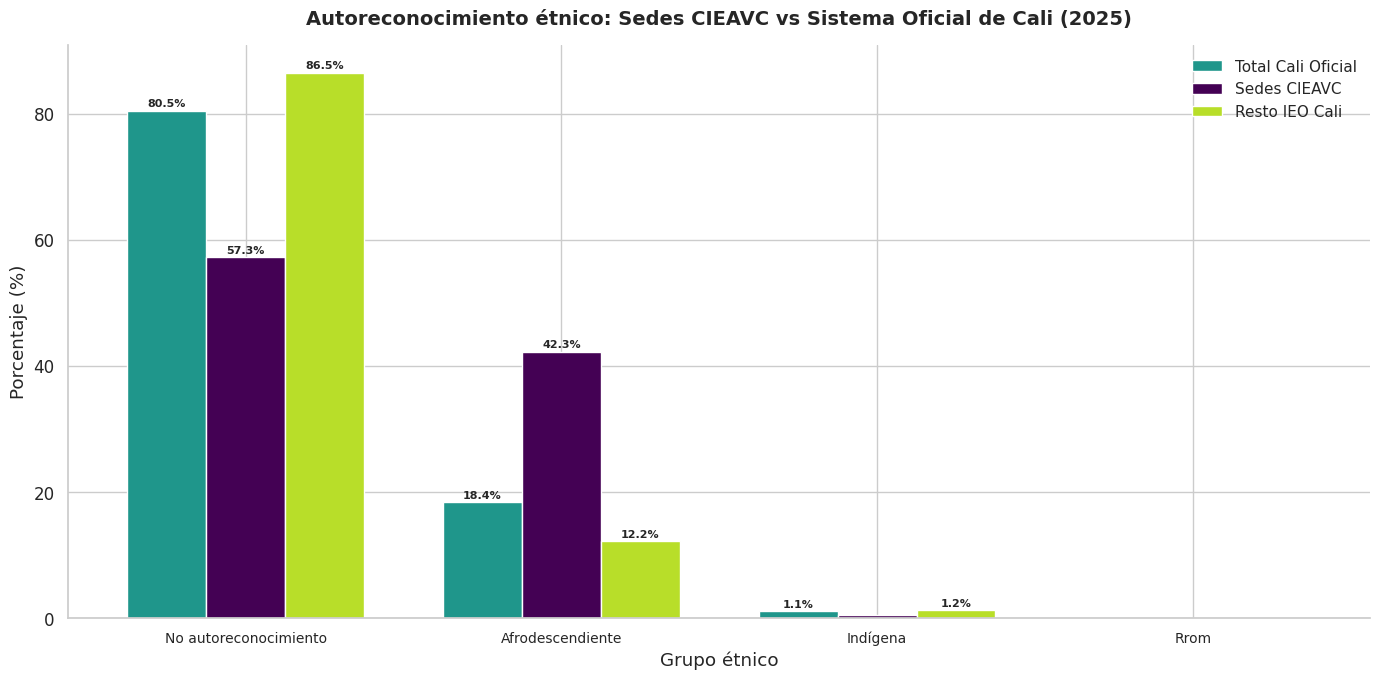


Tabla resumen - Composición étnica (2025):


,Total Cali,Sedes CIEAVC,Resto IEO,n Cali,n CIEAVC
ETNIA_CAT,,,,,
No autoreconocimiento,80.5%,57.3%,86.5%,"114,418","16,745"
Afrodescendiente,18.4%,42.3%,12.2%,"26,160","12,354"
Indígena,1.1%,0.5%,1.2%,"1,531",135
Rrom,0.0%,0.0%,0.0%,8,0


In [27]:

# ============================================================
# BLOQUE 3: Comparación de autoreconocimiento étnico (2025)
# CIEAVC vs Total IEO Cali
# ============================================================

cali_2025 = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == 2025].copy()
cali_2025['ETNIA_CAT'] = cali_2025['ETNIA'].apply(clasificar_etnia)

etnia_cieavc = cali_2025[cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts(normalize=True) * 100
etnia_cali = cali_2025['ETNIA_CAT'].value_counts(normalize=True) * 100
etnia_resto = cali_2025[~cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts(normalize=True) * 100

orden_etnia = ['No autoreconocimiento', 'Afrodescendiente', 'Indígena', 'Rrom', 'Sin dato']
orden_etnia = [e for e in orden_etnia if e in etnia_cali.index]

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(orden_etnia))
w = 0.25

bars1 = ax.bar(x - w, etnia_cali.reindex(orden_etnia, fill_value=0), w,
               label='Total Cali Oficial', color=c_total_cali, edgecolor='white')
bars2 = ax.bar(x, etnia_cieavc.reindex(orden_etnia, fill_value=0), w,
               label='Sedes CIEAVC', color=c_cieavc, edgecolor='white')
bars3 = ax.bar(x + w, etnia_resto.reindex(orden_etnia, fill_value=0), w,
               label='Resto IEO Cali', color=c_resto, edgecolor='white')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        val = bar.get_height()
        if val > 0.5:
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.3,
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_title('Autoreconocimiento étnico: Sedes CIEAVC vs Sistema Oficial de Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Grupo étnico')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(x)
ax.set_xticklabels(orden_etnia, fontsize=10)
ax.legend(frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Composición étnica (2025):")
tabla_etnia = pd.DataFrame({
    'Total Cali': etnia_cali.reindex(orden_etnia, fill_value=0).apply(lambda x: f'{x:.1f}%'),
    'Sedes CIEAVC': etnia_cieavc.reindex(orden_etnia, fill_value=0).apply(lambda x: f'{x:.1f}%'),
    'Resto IEO': etnia_resto.reindex(orden_etnia, fill_value=0).apply(lambda x: f'{x:.1f}%'),
})
n_cali = cali_2025['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
n_cieavc = cali_2025[cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
tabla_etnia['n Cali'] = n_cali.apply(lambda x: f'{x:,}')
tabla_etnia['n CIEAVC'] = n_cieavc.apply(lambda x: f'{x:,}')
display(tabla_etnia)


# ============================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# ============================================================



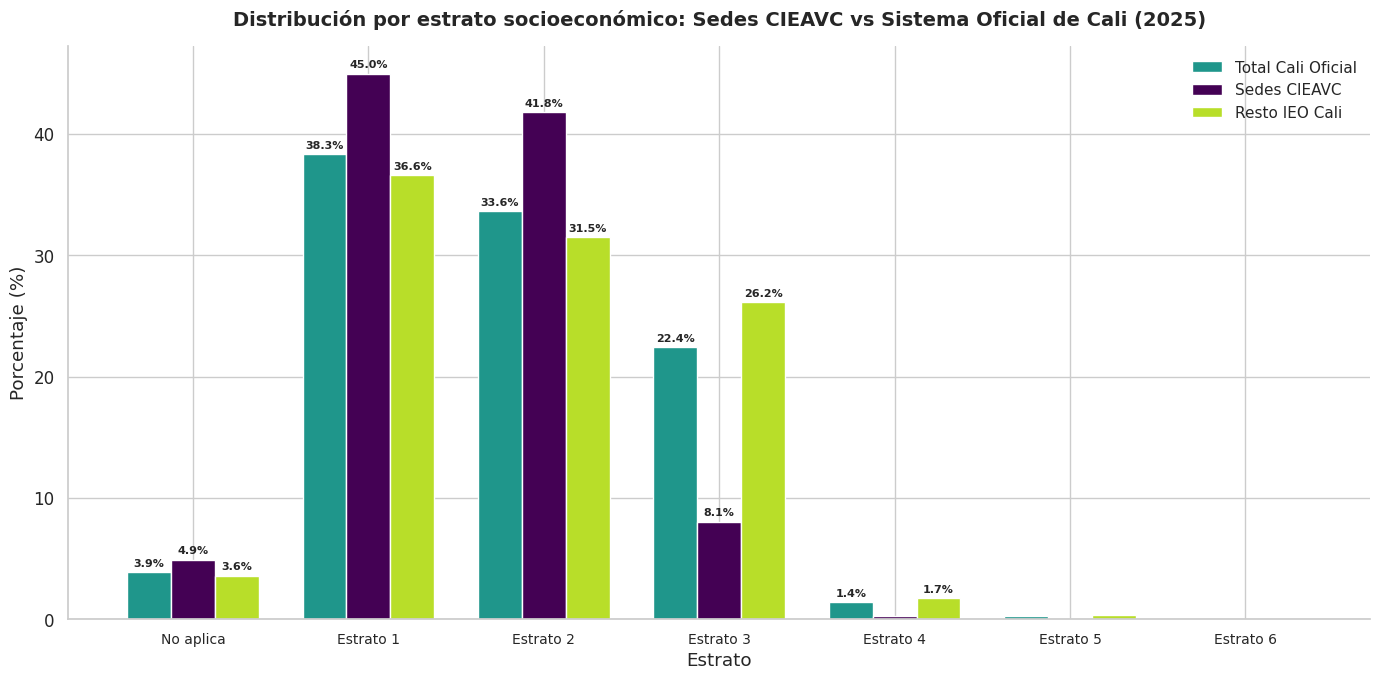


Tabla resumen - Distribución por estrato (2025):


,Total Cali,Sedes CIEAVC,Resto IEO,n Cali,n CIEAVC
ESTRATO_CAT,,,,,
No aplica,3.9%,4.9%,3.6%,"5,501","1,435"
Estrato 1,38.3%,45.0%,36.6%,"54,488","13,144"
Estrato 2,33.6%,41.8%,31.5%,"47,781","12,217"
Estrato 3,22.4%,8.1%,26.2%,"31,883","2,355"
Estrato 4,1.4%,0.2%,1.7%,"2,018",68
Estrato 5,0.3%,0.0%,0.3%,403,13
Estrato 6,0.0%,0.0%,0.0%,43,2


In [28]:


# ============================================================
# BLOQUE 4: Comparación de Estrato Socioeconómico (2025)
# CIEAVC vs Total IEO Cali
# ============================================================

cali_2025['ESTRATO_CAT'] = cali_2025['ESTRATO'].apply(
    lambda x: 'No aplica' if x in [0, 9] else f'Estrato {int(x)}' if pd.notna(x) else 'Sin dato'
)

orden_estrato = ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']

estrato_cieavc = cali_2025[cali_2025['ES_CIEAVC']]['ESTRATO_CAT'].value_counts(normalize=True) * 100
estrato_cali = cali_2025['ESTRATO_CAT'].value_counts(normalize=True) * 100
estrato_resto = cali_2025[~cali_2025['ES_CIEAVC']]['ESTRATO_CAT'].value_counts(normalize=True) * 100

orden_estrato = [e for e in orden_estrato if e in estrato_cali.index]

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(orden_estrato))
w = 0.25

bars1 = ax.bar(x - w, estrato_cali.reindex(orden_estrato, fill_value=0), w,
               label='Total Cali Oficial', color=c_total_cali, edgecolor='white')
bars2 = ax.bar(x, estrato_cieavc.reindex(orden_estrato, fill_value=0), w,
               label='Sedes CIEAVC', color=c_cieavc, edgecolor='white')
bars3 = ax.bar(x + w, estrato_resto.reindex(orden_estrato, fill_value=0), w,
               label='Resto IEO Cali', color=c_resto, edgecolor='white')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        val = bar.get_height()
        if val > 0.5:
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.3,
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_title('Distribución por estrato socioeconómico: Sedes CIEAVC vs Sistema Oficial de Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Estrato')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(x)
ax.set_xticklabels(orden_estrato, fontsize=10)
ax.legend(frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Distribución por estrato (2025):")
tabla_estrato = pd.DataFrame({
    'Total Cali': estrato_cali.reindex(orden_estrato, fill_value=0).apply(lambda x: f'{x:.1f}%'),
    'Sedes CIEAVC': estrato_cieavc.reindex(orden_estrato, fill_value=0).apply(lambda x: f'{x:.1f}%'),
    'Resto IEO': estrato_resto.reindex(orden_estrato, fill_value=0).apply(lambda x: f'{x:.1f}%'),
})
n_cali_e = cali_2025['ESTRATO_CAT'].value_counts().reindex(orden_estrato, fill_value=0)
n_cieavc_e = cali_2025[cali_2025['ES_CIEAVC']]['ESTRATO_CAT'].value_counts().reindex(orden_estrato, fill_value=0)
tabla_estrato['n Cali'] = n_cali_e.apply(lambda x: f'{x:,}')
tabla_estrato['n CIEAVC'] = n_cieavc_e.apply(lambda x: f'{x:,}')
display(tabla_estrato)

Tasa global de deserción (50 sedes CIEAVC, 2025): 6.08%
  Matrícula: 29,234 | Desertores: 1,776

GENERO  - SIMAT: ['F', 'M'] | SIMPADE: ['F', 'M']
NIVEL   - SIMAT: ['Aceleración', 'Básica primaria', 'Básica secundaria', 'Ciclos de adultos', 'Educación inicial', 'Media']
          SIMPADE: ['Aceleración', 'Básica primaria', 'Básica secundaria', 'Ciclos de adultos', 'Media', 'Otro']
ETNIA   - SIMAT: ['Afrodescendiente', 'Indígena', 'No autoreconocimiento']
          SIMPADE: ['Afrodescendiente', 'Indígena', 'No autoreconocimiento', 'Rrom']

3.1 Sexo × Nivel educativo → Tasa de deserción (50 sedes CIEAVC)


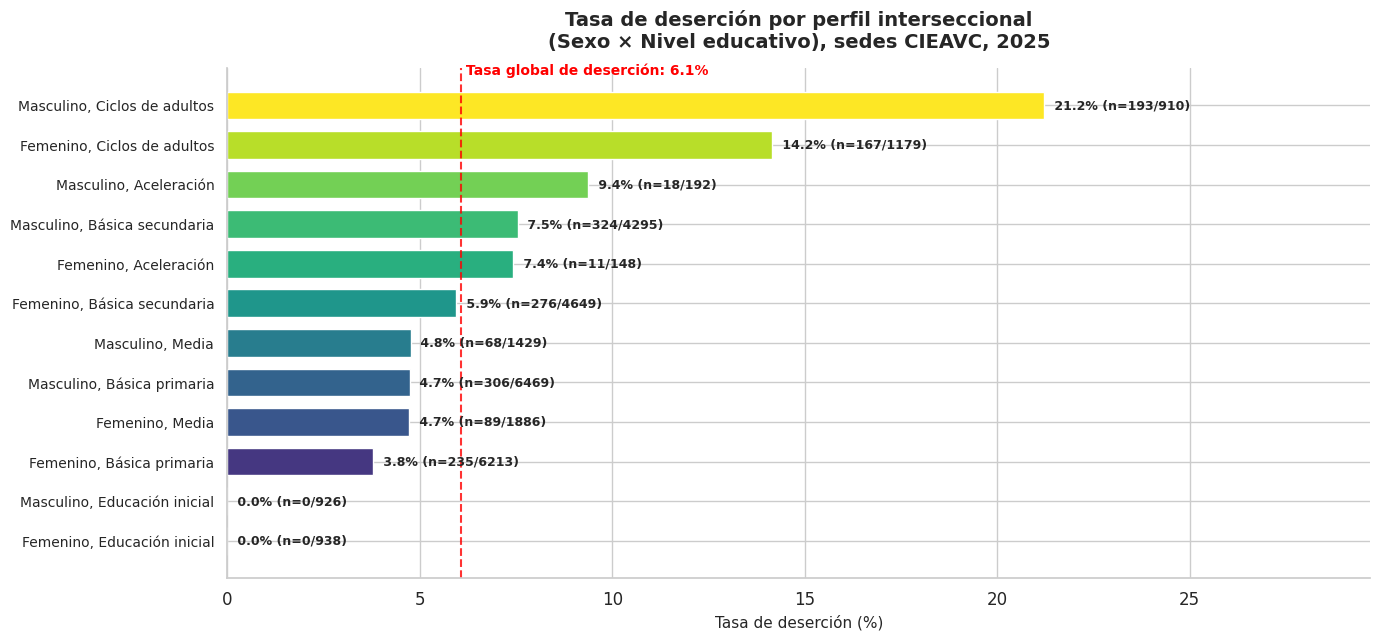


3.3 Sexo × Etnia → Tasa de deserción (50 sedes CIEAVC)


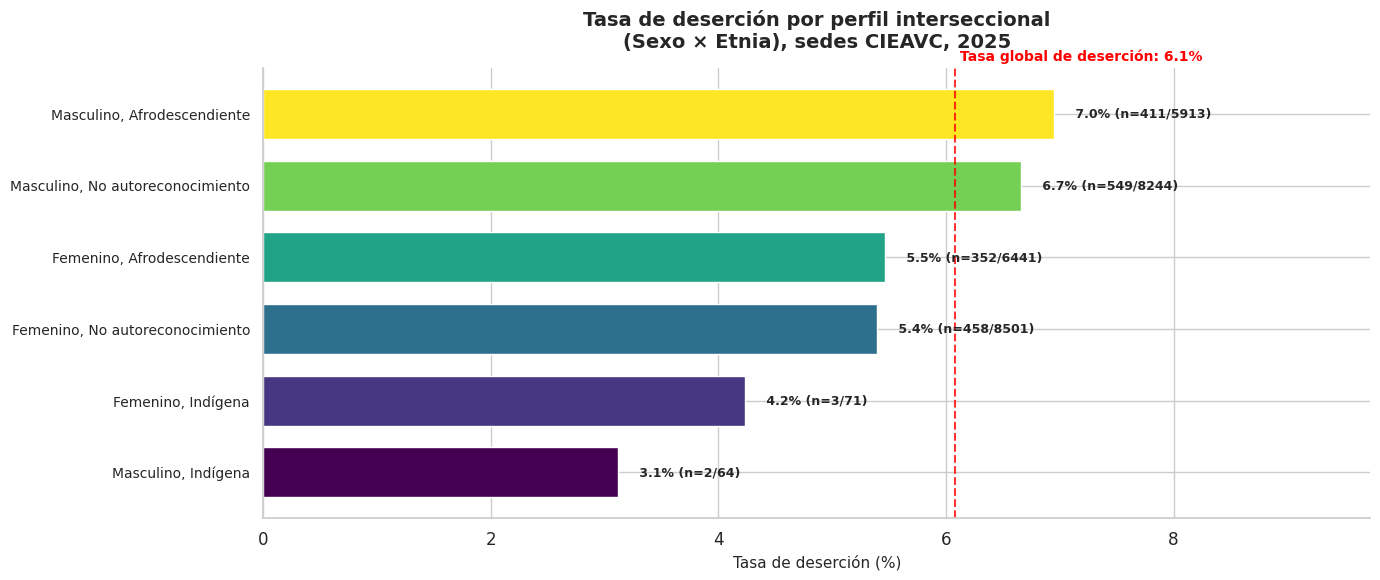

In [29]:

# ============================================================
# BLOQUE 5: Análisis interseccional ajustado (TODAS las 50 sedes)
# ============================================================
# Pegar como nueva celda de código
# NOTA: Este bloque reemplaza el análisis interseccional anterior (top 10).
# Requiere que se hayan ejecutado los bloques de homologación de SIMPADE.

# --- Homologar SIMPADE (si no se hizo antes) ---
if SIMPADE['GENERO'].dtype == 'object' and 'MASCULINO' in SIMPADE['GENERO'].values:
    SIMPADE['GENERO'] = SIMPADE['GENERO'].str.strip().str.upper().map(
        {'MASCULINO': 'M', 'FEMENINO': 'F', 'M': 'M', 'F': 'F'}
    )

# --- Datos 2025: todas las 50 sedes ---
df_2025_all = SIMAT[SIMAT['ANO_INF'] == 2025].copy()
spd_2025_all = SIMPADE[SIMPADE['ANNO_INF'] == 2025].copy()

# Asegurar tipos de llave
df_2025_all['DANE_ANTERIOR'] = df_2025_all['DANE_ANTERIOR'].astype('Int64')
spd_2025_all['SPD_DANE_SEDE'] = spd_2025_all['SPD_DANE_SEDE'].astype('Int64')

# Filtrar SIMPADE solo a nuestras 50 sedes
nuestras_sedes = df_2025_all['DANE_ANTERIOR'].unique()
spd_2025_all = spd_2025_all[spd_2025_all['SPD_DANE_SEDE'].isin(nuestras_sedes)].copy()

# --- Clasificaciones ---
def clasificar_nivel_numerico(grado):
    if pd.isna(grado): return 'Sin dato'
    try:
        grado = int(grado)
    except (ValueError, TypeError):
        return 'Sin dato'
    if grado in [-2, -1, 0]: return 'Educación inicial'
    elif 1 <= grado <= 5: return 'Básica primaria'
    elif 6 <= grado <= 9: return 'Básica secundaria'
    elif grado in [10, 11]: return 'Media'
    elif 21 <= grado <= 26: return 'Ciclos de adultos'
    elif grado == 99: return 'Aceleración'
    else: return 'Otro'

GRADO_TEXTO_A_NIVEL = {
    'PRE-JARDÍN': 'Educación inicial', 'PREJARDÍN': 'Educación inicial',
    'JARDÍN': 'Educación inicial', 'JARDIN': 'Educación inicial',
    'TRANSICIÓN': 'Educación inicial', 'TRANSICION': 'Educación inicial',
    'PRIMERO': 'Básica primaria', 'SEGUNDO': 'Básica primaria',
    'TERCERO': 'Básica primaria', 'CUARTO': 'Básica primaria',
    'QUINTO': 'Básica primaria',
    'SEXTO': 'Básica secundaria', 'SÉPTIMO': 'Básica secundaria',
    'SEPTIMO': 'Básica secundaria', 'OCTAVO': 'Básica secundaria',
    'NOVENO': 'Básica secundaria',
    'DÉCIMO': 'Media', 'DECIMO': 'Media',
    'ONCE': 'Media', 'UNDÉCIMO': 'Media', 'UNDECIMO': 'Media',
    'CICLO 1': 'Ciclos de adultos', 'CICLO 2': 'Ciclos de adultos',
    'CICLO 3': 'Ciclos de adultos', 'CICLO 4': 'Ciclos de adultos',
    'CICLO 5': 'Ciclos de adultos', 'CICLO 6': 'Ciclos de adultos',
    'ACELERACIÓN': 'Aceleración', 'ACELERACION': 'Aceleración',
}

def clasificar_nivel_texto(grado):
    if pd.isna(grado): return 'Sin dato'
    grado_str = str(grado).strip().upper()
    try:
        return clasificar_nivel_numerico(int(grado))
    except (ValueError, TypeError):
        pass
    if grado_str in GRADO_TEXTO_A_NIVEL:
        return GRADO_TEXTO_A_NIVEL[grado_str]
    for key, val in GRADO_TEXTO_A_NIVEL.items():
        if key in grado_str or grado_str in key:
            return val
    return 'Otro'

def clasificar_etnia_num(codigo):
    if pd.isna(codigo): return 'Sin dato'
    try:
        codigo = int(codigo)
    except (ValueError, TypeError):
        return 'Sin dato'
    if codigo == 0: return 'No autoreconocimiento'
    elif codigo == 400: return 'Rrom'
    elif codigo in [97, 98, 200]: return 'Afrodescendiente'
    else: return 'Indígena'

AFRO_TEXTOS = ['AFRODESCENDIENTE', 'NEGRITUDES', 'PALANQUERO']
RROM_TEXTOS = ['ROM', 'RROM', 'GITANO']
NO_APLICA_TEXTOS = ['NO APLICA', 'NINGUNO', 'NO REPORTA']

def clasificar_etnia_texto(etnia):
    if pd.isna(etnia): return 'Sin dato'
    etnia_upper = str(etnia).strip().upper()
    if etnia_upper in NO_APLICA_TEXTOS:
        return 'No autoreconocimiento'
    if any(a in etnia_upper for a in AFRO_TEXTOS):
        return 'Afrodescendiente'
    if any(r in etnia_upper for r in RROM_TEXTOS):
        return 'Rrom'
    return 'Indígena'

# Aplicar
df_2025_all['NIVEL_EDUCATIVO'] = df_2025_all['GRADO'].apply(clasificar_nivel_numerico)
df_2025_all['ETNIA_CAT'] = df_2025_all['ETNIA'].apply(clasificar_etnia_num)

spd_2025_all['NIVEL_EDUCATIVO'] = spd_2025_all['GRADO'].apply(clasificar_nivel_texto)
spd_2025_all['ETNIA_CAT'] = spd_2025_all['ETNIA'].apply(clasificar_etnia_texto)

# --- Tasa global ---
tasa_global = len(spd_2025_all) / len(df_2025_all) * 100
print(f"Tasa global de deserción (50 sedes CIEAVC, 2025): {tasa_global:.2f}%")
print(f"  Matrícula: {len(df_2025_all):,} | Desertores: {len(spd_2025_all):,}")

# --- Verificación ---
print(f"\nGENERO  - SIMAT: {sorted(df_2025_all['GENERO'].dropna().unique())} | SIMPADE: {sorted(spd_2025_all['GENERO'].dropna().unique())}")
print(f"NIVEL   - SIMAT: {sorted(df_2025_all['NIVEL_EDUCATIVO'].unique())}")
print(f"          SIMPADE: {sorted(spd_2025_all['NIVEL_EDUCATIVO'].unique())}")
print(f"ETNIA   - SIMAT: {sorted(df_2025_all['ETNIA_CAT'].unique())}")
print(f"          SIMPADE: {sorted(spd_2025_all['ETNIA_CAT'].unique())}")


# ============================================================
# Función de gráfico (misma que antes)
# ============================================================
def grafico_desercion_interseccional(df_mat, df_des, variables, titulo, tasa_global, min_n=30):
    mat_perfil = df_mat.groupby(variables).size().reset_index(name='MATRICULA')
    des_perfil = df_des.groupby(variables).size().reset_index(name='DESERTORES')

    merged = mat_perfil.merge(des_perfil, on=variables, how='left')
    merged['DESERTORES'] = merged['DESERTORES'].fillna(0).astype(int)
    merged['TASA_DESERCION'] = (merged['DESERTORES'] / merged['MATRICULA'] * 100).round(2)
    merged = merged[merged['MATRICULA'] >= min_n].copy()

    def etiquetar(row):
        partes = []
        for col in variables:
            val = row[col]
            if col == 'GENERO':
                val = 'Femenino' if val == 'F' else 'Masculino'
            partes.append(str(val))
        return ', '.join(partes)

    merged['PERFIL'] = merged.apply(etiquetar, axis=1)
    merged = merged.sort_values('TASA_DESERCION', ascending=True).reset_index(drop=True)

    n_barras = len(merged)
    colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]

    fig, ax = plt.subplots(figsize=(14, max(6, n_barras * 0.55)))
    ax.barh(range(n_barras), merged['TASA_DESERCION'].values,
            color=colores, edgecolor='white', height=0.7)

    for i, (_, row) in enumerate(merged.iterrows()):
        ax.text(row['TASA_DESERCION'] + 0.15, i,
                f" {row['TASA_DESERCION']:.1f}% (n={int(row['DESERTORES'])}/{int(row['MATRICULA'])})",
                va='center', fontsize=9, fontweight='bold')

    ax.axvline(tasa_global, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(tasa_global, n_barras - 0.3,
            f' Tasa global de deserción: {tasa_global:.1f}%',
            color='red', fontsize=10, fontweight='bold', va='bottom')

    ax.set_yticks(range(n_barras))
    ax.set_yticklabels(merged['PERFIL'].values, fontsize=10)
    ax.set_xlabel('Tasa de deserción (%)', fontsize=11)
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=15)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(0, max(merged['TASA_DESERCION'].max() * 1.4, tasa_global * 1.5))

    plt.tight_layout()
    plt.show()
    return merged


# ============================================================
# 3.1 Sexo × Nivel educativo (todas las 50 sedes)
# ============================================================
print("\n" + "="*70)
print("3.1 Sexo × Nivel educativo → Tasa de deserción (50 sedes CIEAVC)")
print("="*70)

result_31 = grafico_desercion_interseccional(
    df_mat=df_2025_all, df_des=spd_2025_all,
    variables=['GENERO', 'NIVEL_EDUCATIVO'],
    titulo='Tasa de deserción por perfil interseccional\n(Sexo × Nivel educativo), sedes CIEAVC, 2025',
    tasa_global=tasa_global, min_n=30
)

# ============================================================
# 3.3 Sexo × Etnia (todas las 50 sedes)
# ============================================================
print("\n" + "="*70)
print("3.3 Sexo × Etnia → Tasa de deserción (50 sedes CIEAVC)")
print("="*70)

result_33 = grafico_desercion_interseccional(
    df_mat=df_2025_all, df_des=spd_2025_all,
    variables=['GENERO', 'ETNIA_CAT'],
    titulo='Tasa de deserción por perfil interseccional\n(Sexo × Etnia), sedes CIEAVC, 2025',
    tasa_global=tasa_global, min_n=30
)

OPCIÓN A: Barras apiladas al 100%


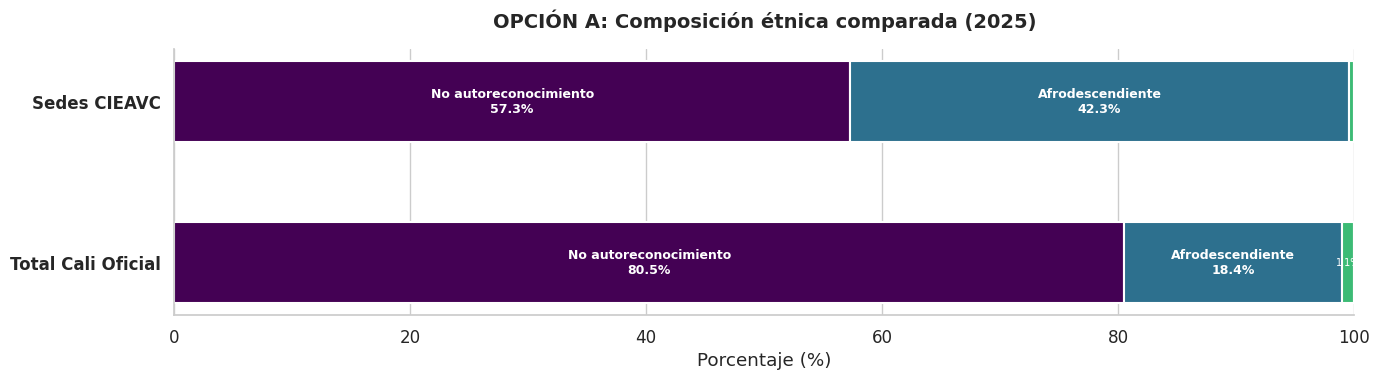


OPCIÓN B: Gráfico de diferencias (lollipop)


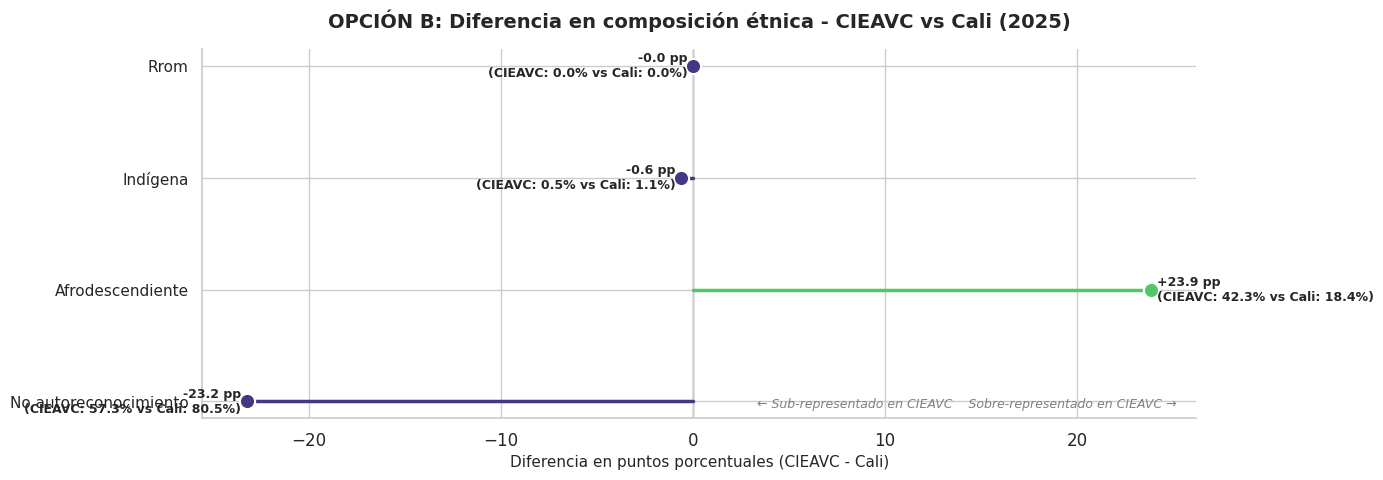


OPCIÓN C: Barras apiladas (como matrícula)


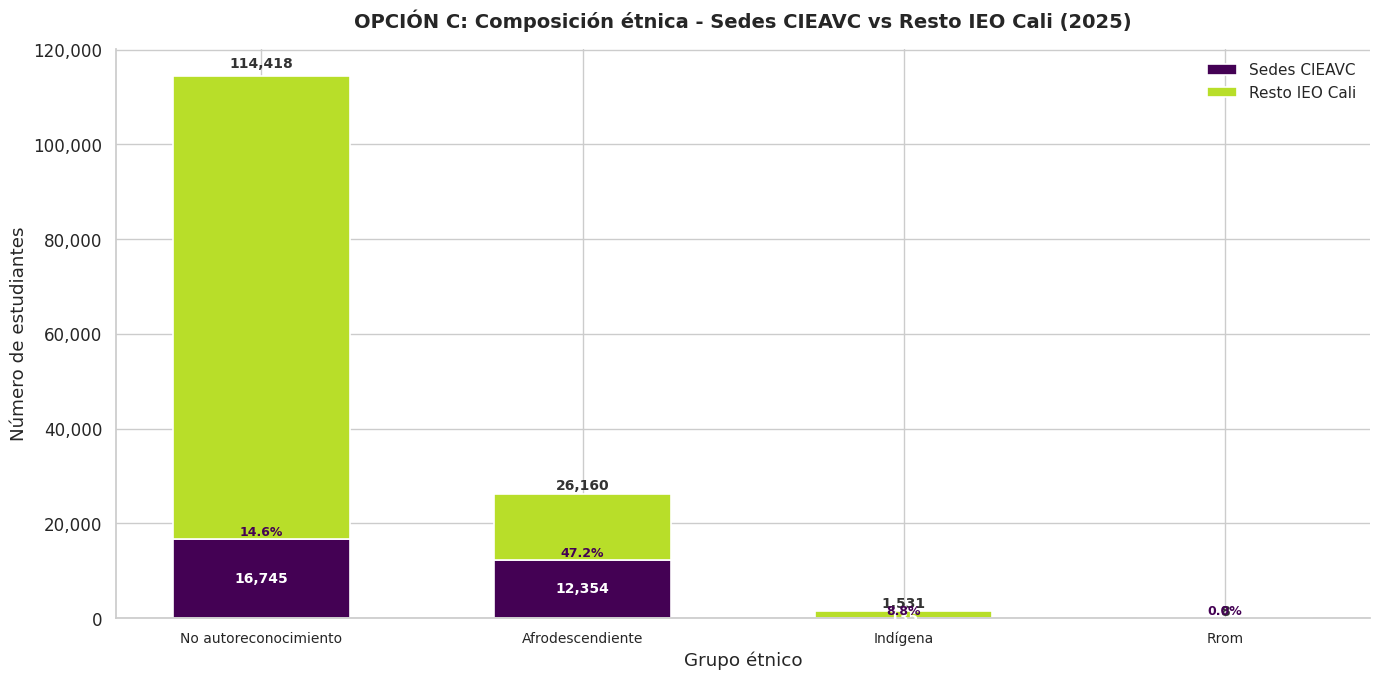


EVOLUCIÓN TEMPORAL: Composición étnica


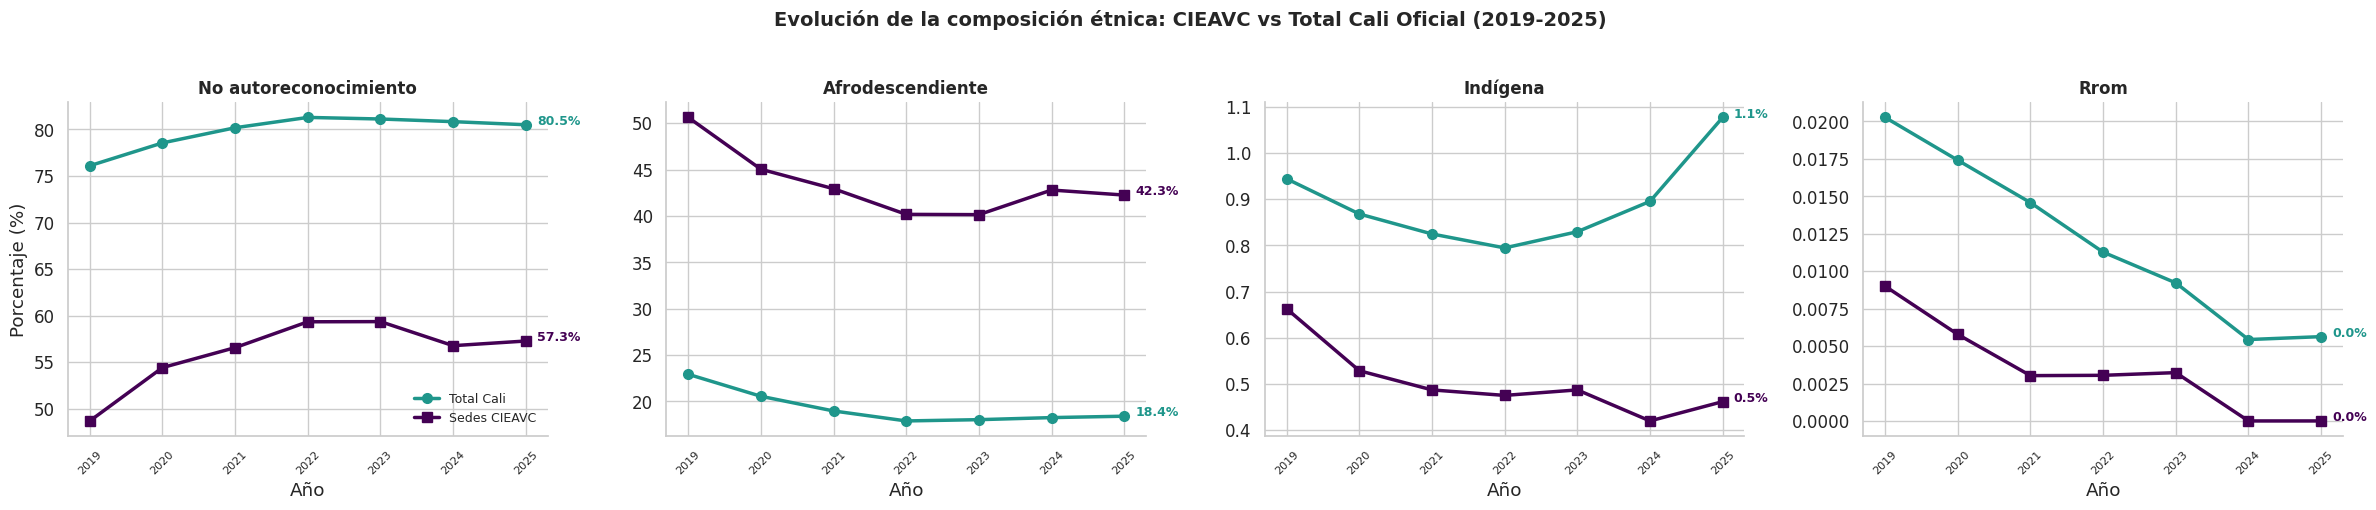


Tabla resumen - Evolución étnica:


Año,2019,2020,2021,2022,2023,2024,2025
No autoreconocimiento - Cali (%),76.1,78.6,80.2,81.3,81.1,80.8,80.5
No autoreconocimiento - CIEAVC (%),48.7,54.4,56.6,59.3,59.4,56.8,57.3


Año,2019,2020,2021,2022,2023,2024,2025
Afrodescendiente - Cali (%),22.9,20.6,19.0,17.9,18.0,18.3,18.4
Afrodescendiente - CIEAVC (%),50.6,45.0,42.9,40.2,40.1,42.8,42.3


Año,2019,2020,2021,2022,2023,2024,2025
Indígena - Cali (%),0.9,0.9,0.8,0.8,0.8,0.9,1.1
Indígena - CIEAVC (%),0.7,0.5,0.5,0.5,0.5,0.4,0.5


Año,2019,2020,2021,2022,2023,2024,2025
Rrom - Cali (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rrom - CIEAVC (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# ============================================================
# OPCIONES DE VISUALIZACIÓN - Etnia CIEAVC vs Cali (2025)
# Ejecuta las 3 y escoge la que más te guste
# ============================================================

# --- Preparar datos ---
cali_2025 = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == 2025].copy()
cali_2025['ETNIA_CAT'] = cali_2025['ETNIA'].apply(clasificar_etnia)

c_cieavc = palette[0]      # morado oscuro
c_resto = palette[17]       # amarillo verdoso
c_total_cali = palette[10]  # verde azulado

orden_etnia = ['No autoreconocimiento', 'Afrodescendiente', 'Indígena', 'Rrom']

etnia_cieavc_pct = cali_2025[cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts(normalize=True).reindex(orden_etnia, fill_value=0) * 100
etnia_cali_pct = cali_2025['ETNIA_CAT'].value_counts(normalize=True).reindex(orden_etnia, fill_value=0) * 100

etnia_cieavc_n = cali_2025[cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
etnia_cali_n = cali_2025['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
etnia_resto_n = (etnia_cali_n - etnia_cieavc_n)


# ============================================================
# OPCIÓN A: Barras apiladas al 100% (dos barras horizontales)
# ============================================================
print("="*70)
print("OPCIÓN A: Barras apiladas al 100%")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 4))

categorias = ['Total Cali Oficial', 'Sedes CIEAVC']
datos = [etnia_cali_pct, etnia_cieavc_pct]

# Colores para cada categoría étnica (de la paleta)
colores_etnia = [palette[0], palette[7], palette[13], palette[17]]

for i, (label, data) in enumerate(zip(categorias, datos)):
    left = 0
    for j, cat in enumerate(orden_etnia):
        val = data[cat]
        bar = ax.barh(i, val, left=left, height=0.5,
                      color=colores_etnia[j], edgecolor='white', linewidth=1.5)
        # Etiqueta solo si el segmento es visible
        if val > 3:
            ax.text(left + val/2, i, f'{cat}\n{val:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        elif val > 0.5:
            ax.text(left + val/2, i, f'{val:.1f}%',
                    ha='center', va='center', fontsize=7, color='white')
        left += val

ax.set_yticks([0, 1])
ax.set_yticklabels(categorias, fontsize=12, fontweight='bold')
ax.set_xlabel('Porcentaje (%)')
ax.set_title('OPCIÓN A: Composición étnica comparada (2025)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 100)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


# ============================================================
# OPCIÓN B: Gráfico de diferencias (lollipop)
# ============================================================
print("\n" + "="*70)
print("OPCIÓN B: Gráfico de diferencias (lollipop)")
print("="*70)

diferencias = etnia_cieavc_pct - etnia_cali_pct

fig, ax = plt.subplots(figsize=(14, 5))

y_pos = np.arange(len(orden_etnia))
colores_diff = [palette[3] if d < 0 else palette[14] for d in diferencias.values]

# Líneas desde 0 hasta el punto
for i, (cat, diff) in enumerate(zip(orden_etnia, diferencias.values)):
    ax.plot([0, diff], [i, i], color=colores_diff[i], linewidth=2.5, zorder=1)
    ax.scatter(diff, i, color=colores_diff[i], s=120, zorder=2, edgecolors='white', linewidth=1.5)
    # Etiqueta
    offset = 0.3 if diff >= 0 else -0.3
    ha = 'left' if diff >= 0 else 'right'
    ax.text(diff + offset, i,
            f'{diff:+.1f} pp\n(CIEAVC: {etnia_cieavc_pct[cat]:.1f}% vs Cali: {etnia_cali_pct[cat]:.1f}%)',
            va='center', ha=ha, fontsize=9, fontweight='bold')

ax.axvline(0, color='gray', linewidth=1, linestyle='-', zorder=0)
ax.set_yticks(y_pos)
ax.set_yticklabels(orden_etnia, fontsize=11)
ax.set_xlabel('Diferencia en puntos porcentuales (CIEAVC - Cali)', fontsize=11)
ax.set_title('OPCIÓN B: Diferencia en composición étnica - CIEAVC vs Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.spines[['top', 'right']].set_visible(False)

# Leyenda manual
ax.text(0.98, 0.02, '← Sub-representado en CIEAVC    Sobre-representado en CIEAVC →',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
        style='italic', color='gray')

plt.tight_layout()
plt.show()


# ============================================================
# OPCIÓN C: Barras apiladas tipo matrícula (CIEAVC vs Resto)
# ============================================================
print("\n" + "="*70)
print("OPCIÓN C: Barras apiladas (como matrícula)")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(orden_etnia))
w = 0.55

bars_cieavc = ax.bar(x, etnia_cieavc_n.values, w,
                      label='Sedes CIEAVC', color=c_cieavc, edgecolor='white', linewidth=1.2)
bars_resto = ax.bar(x, etnia_resto_n.values, w,
                     bottom=etnia_cieavc_n.values,
                     label='Resto IEO Cali', color=c_resto, edgecolor='white', linewidth=1.2)

for i, cat in enumerate(orden_etnia):
    val_c = etnia_cieavc_n[cat]
    val_total = etnia_cali_n[cat]
    pct = val_c / val_total * 100 if val_total > 0 else 0

    # CIEAVC centrado
    if val_c > 100:
        ax.text(x[i], val_c / 2, f'{val_c:,}',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Total arriba
    ax.text(x[i], val_total + val_total * 0.01, f'{val_total:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # % CIEAVC
    ax.text(x[i], val_c + 100, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, color=c_cieavc, fontweight='bold')

ax.set_title('OPCIÓN C: Composición étnica - Sedes CIEAVC vs Resto IEO Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Grupo étnico')
ax.set_ylabel('Número de estudiantes')
ax.set_xticks(x)
ax.set_xticklabels(orden_etnia, fontsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.legend(loc='upper right', frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


# ============================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# ============================================================


# ============================================================
# EVOLUCIÓN TEMPORAL: Composición étnica CIEAVC vs Cali (2019-2025)
# (Este bloque va después de que escojas la opción)
# ============================================================
print("\n" + "="*70)
print("EVOLUCIÓN TEMPORAL: Composición étnica")
print("="*70)

# Aplicar clasificación a todo SIMAT_CALI
SIMAT_CALI['ETNIA_CAT'] = SIMAT_CALI['ETNIA'].apply(clasificar_etnia)

años = sorted(SIMAT_CALI['ANO_INF'].unique())

# Calcular % por año para CIEAVC y Cali
evol_data = []
for año in años:
    df_año = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == año]
    for cat in orden_etnia:
        pct_cali = (df_año['ETNIA_CAT'] == cat).sum() / len(df_año) * 100
        df_cieavc = df_año[df_año['ES_CIEAVC']]
        pct_cieavc = (df_cieavc['ETNIA_CAT'] == cat).sum() / len(df_cieavc) * 100 if len(df_cieavc) > 0 else 0
        evol_data.append({'Año': año, 'Etnia': cat, '% Cali': pct_cali, '% CIEAVC': pct_cieavc})

evol_df = pd.DataFrame(evol_data)

# Gráfico: una subfigura por categoría étnica
fig, axes = plt.subplots(1, len(orden_etnia), figsize=(6 * len(orden_etnia), 5), sharey=False)

for i, cat in enumerate(orden_etnia):
    ax = axes[i]
    df_cat = evol_df[evol_df['Etnia'] == cat]

    ax.plot(df_cat['Año'], df_cat['% Cali'], marker='o', linewidth=2.5,
            markersize=7, label='Total Cali', color=c_total_cali)
    ax.plot(df_cat['Año'], df_cat['% CIEAVC'], marker='s', linewidth=2.5,
            markersize=7, label='Sedes CIEAVC', color=c_cieavc)

    # Etiqueta último año
    for col, estilo in [('% Cali', c_total_cali), ('% CIEAVC', c_cieavc)]:
        ultimo = df_cat[col].iloc[-1]
        ax.annotate(f'{ultimo:.1f}%', (df_cat['Año'].iloc[-1], ultimo),
                    textcoords='offset points', xytext=(8, 0), fontsize=9,
                    fontweight='bold', color=estilo)

    ax.set_title(cat, fontsize=12, fontweight='bold')
    ax.set_xlabel('Año')
    if i == 0:
        ax.set_ylabel('Porcentaje (%)')
    ax.set_xticks(años)
    ax.set_xticklabels([str(a) for a in años], rotation=45, fontsize=8)
    ax.spines[['top', 'right']].set_visible(False)
    if i == 0:
        ax.legend(frameon=False, fontsize=9)

fig.suptitle('Evolución de la composición étnica: CIEAVC vs Total Cali Oficial (2019-2025)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Evolución étnica:")
for cat in orden_etnia:
    df_cat = evol_df[evol_df['Etnia'] == cat].set_index('Año')
    df_cat = df_cat[['% Cali', '% CIEAVC']].round(1)
    df_cat.columns = [f'{cat} - Cali (%)', f'{cat} - CIEAVC (%)']
    display(df_cat.T)

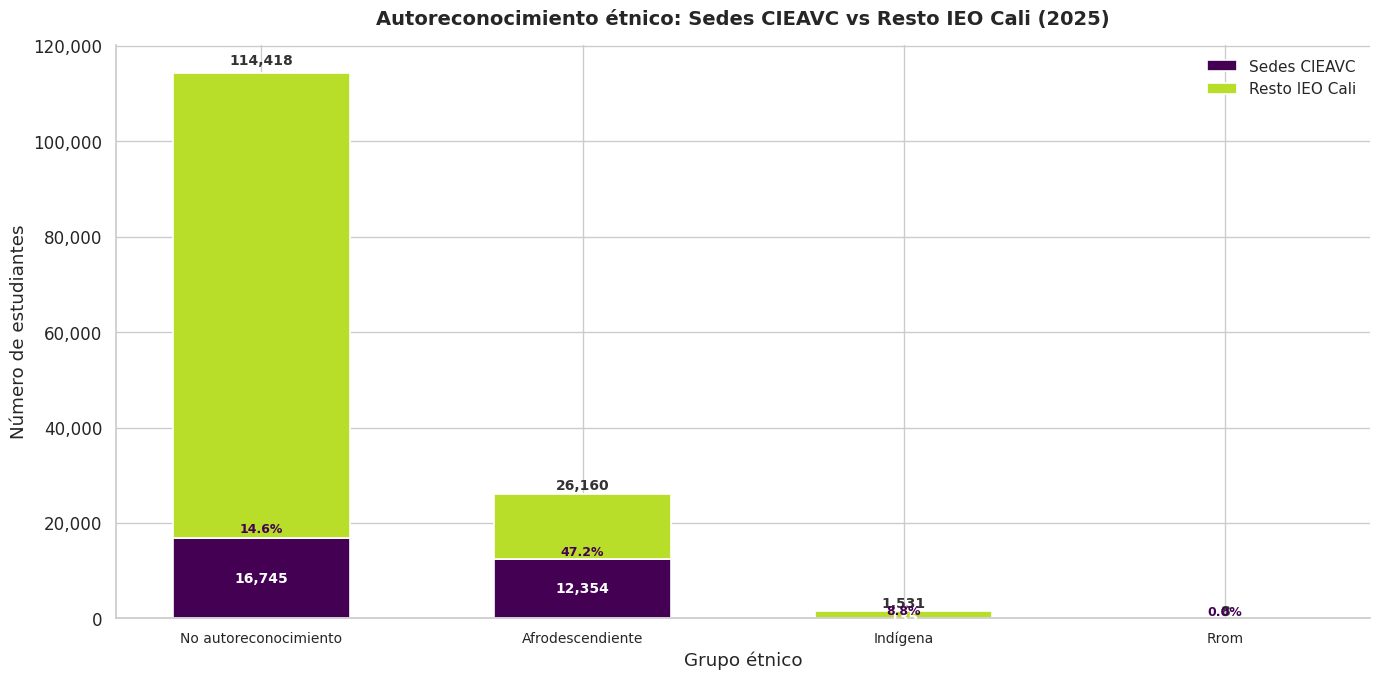


Tabla resumen - Composición étnica (2025):


,CIEAVC (n),CIEAVC (%),Cali total (n),Cali total (%),% CIEAVC del total
ETNIA_CAT,,,,,
No autoreconocimiento,"16,745",57.3%,"114,418",80.5%,14.6%
Afrodescendiente,"12,354",42.3%,"26,160",18.4%,47.2%
Indígena,135,0.5%,"1,531",1.1%,8.8%
Rrom,0,0.0%,8,0.0%,0.0%


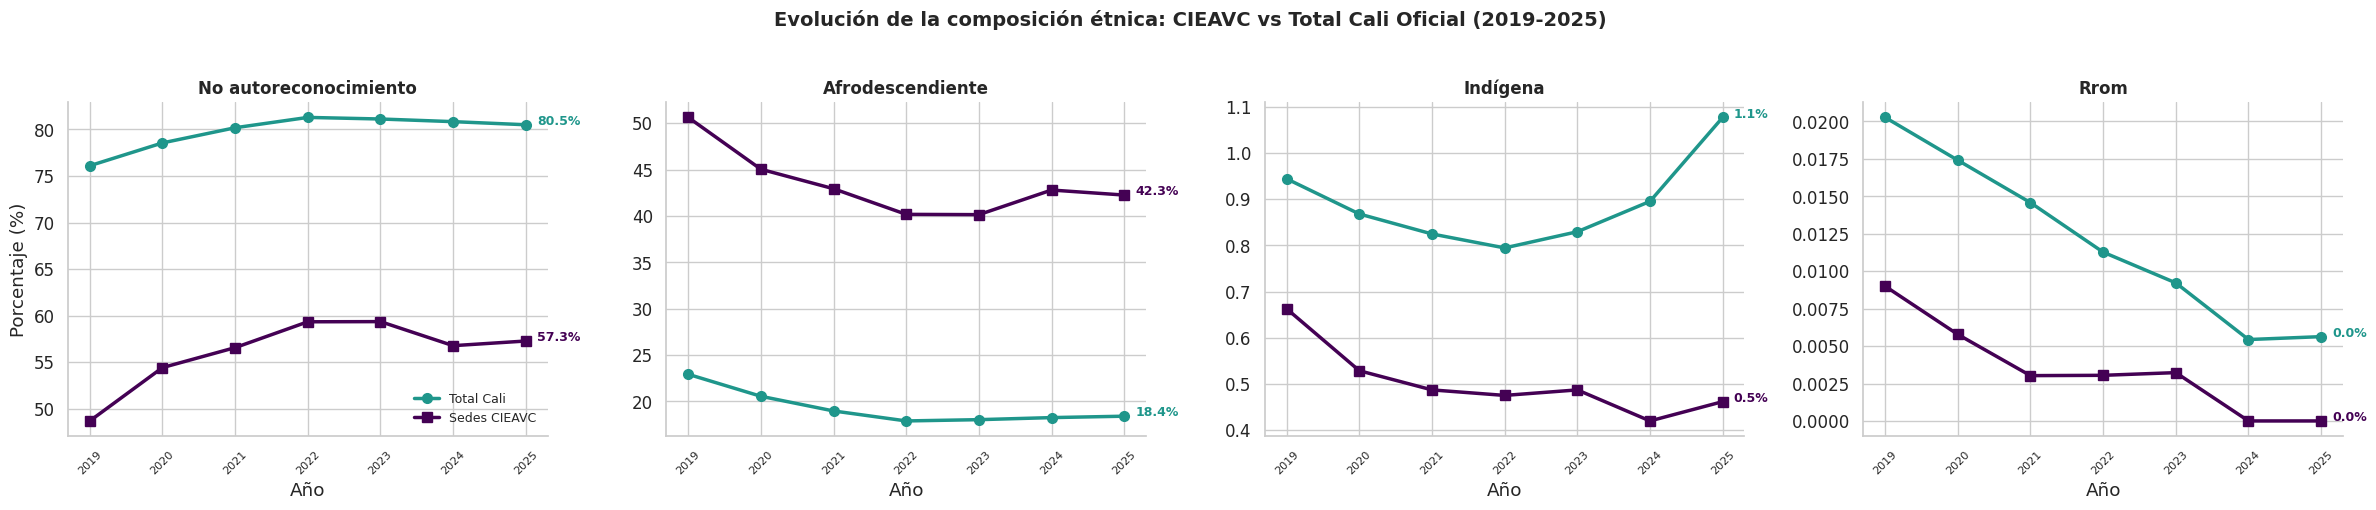

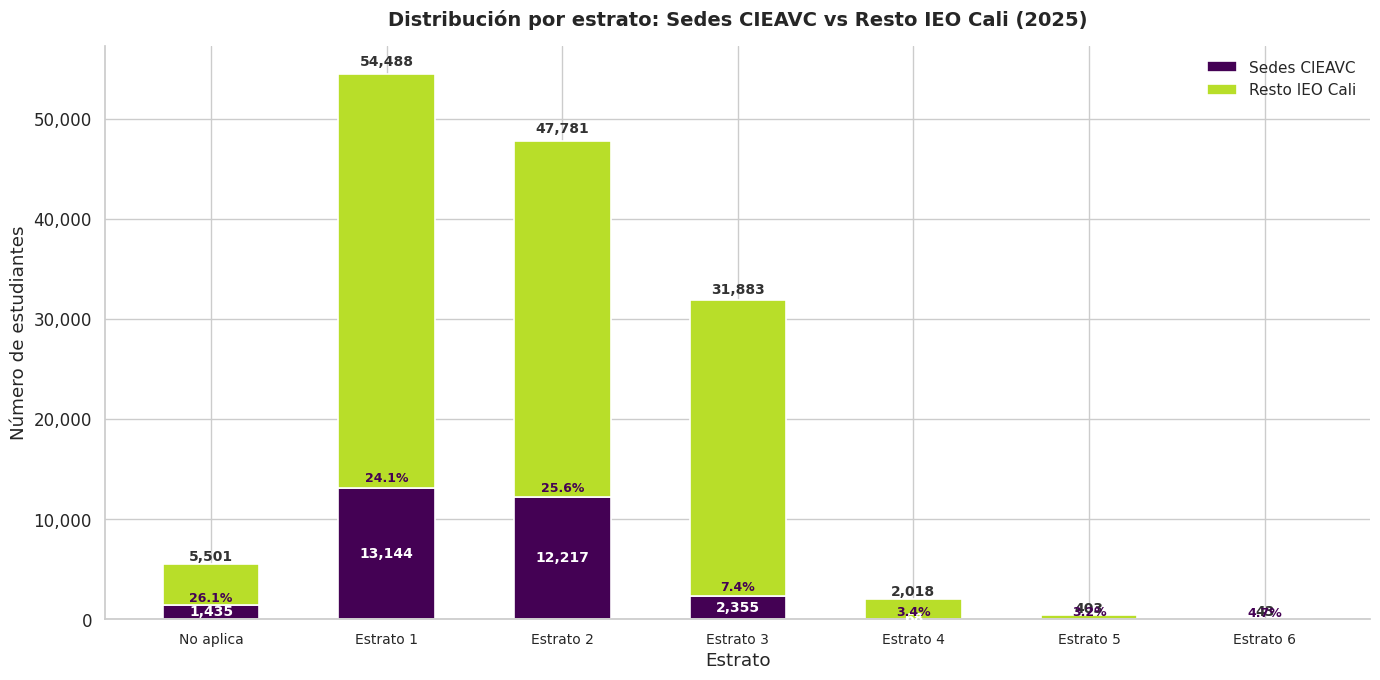


Tabla resumen - Distribución por estrato (2025):


,CIEAVC (n),CIEAVC (%),Cali total (n),Cali total (%),% CIEAVC del total
ESTRATO_CAT,,,,,
No aplica,"1,435",4.9%,"5,501",3.9%,26.1%
Estrato 1,"13,144",45.0%,"54,488",38.3%,24.1%
Estrato 2,"12,217",41.8%,"47,781",33.6%,25.6%
Estrato 3,"2,355",8.1%,"31,883",22.4%,7.4%
Estrato 4,68,0.2%,"2,018",1.4%,3.4%
Estrato 5,13,0.0%,403,0.3%,3.2%
Estrato 6,2,0.0%,43,0.0%,4.7%


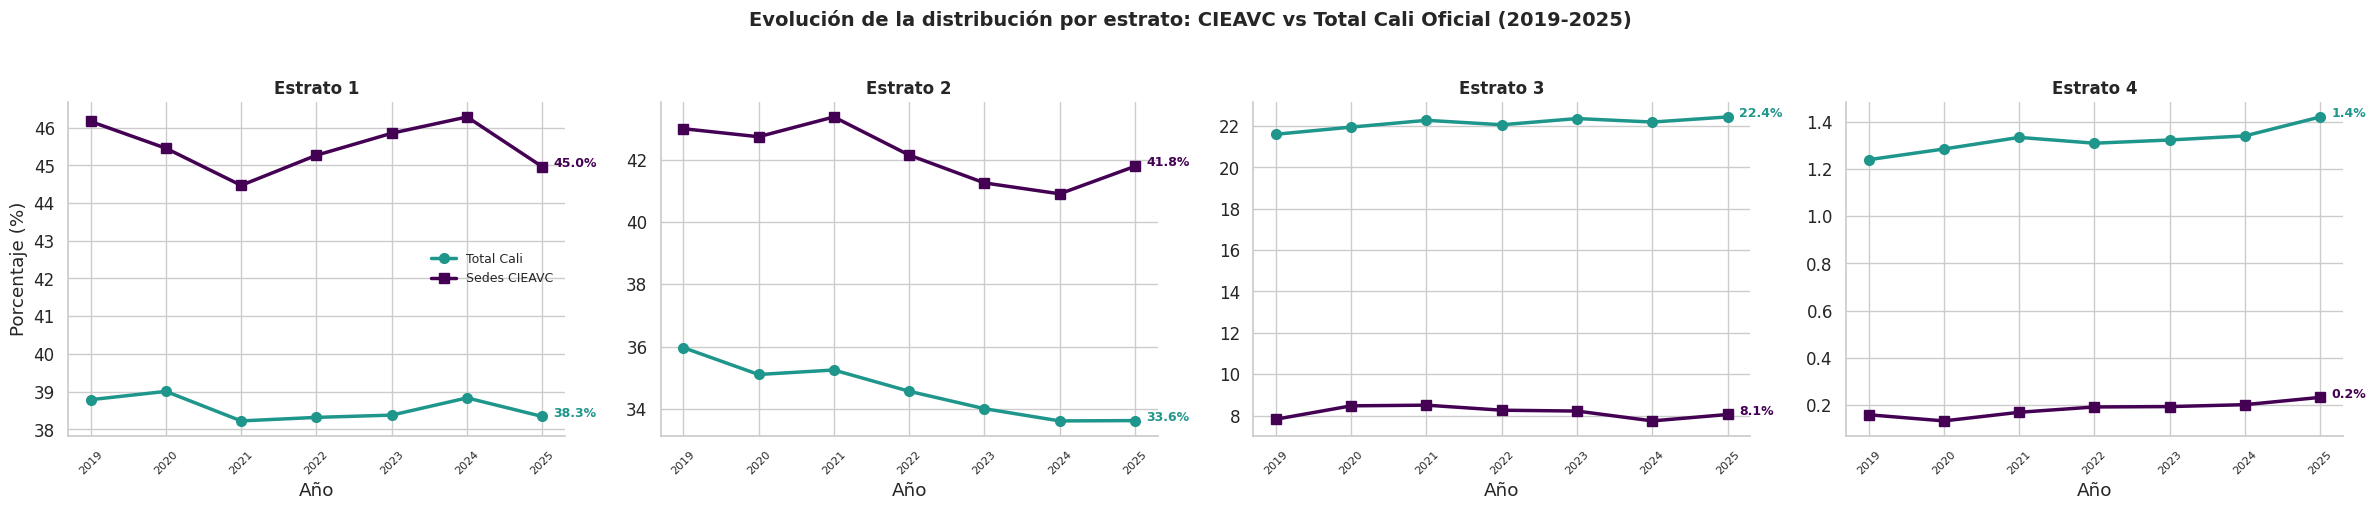

In [31]:
# ============================================================
# BLOQUE 3: Composición étnica - CIEAVC vs Resto IEO Cali
# ============================================================

# --- Colores ---
c_cieavc = palette[0]      # morado oscuro
c_resto = palette[17]       # amarillo verdoso
c_total_cali = palette[10]  # verde azulado

# --- Preparar datos 2025 ---
cali_2025 = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == 2025].copy()
cali_2025['ETNIA_CAT'] = cali_2025['ETNIA'].apply(clasificar_etnia)

orden_etnia = ['No autoreconocimiento', 'Afrodescendiente', 'Indígena', 'Rrom']

etnia_cieavc_n = cali_2025[cali_2025['ES_CIEAVC']]['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
etnia_cali_n = cali_2025['ETNIA_CAT'].value_counts().reindex(orden_etnia, fill_value=0)
etnia_resto_n = etnia_cali_n - etnia_cieavc_n

# --- Barras apiladas (recuentos) ---
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(orden_etnia))
w = 0.55

bars_cieavc = ax.bar(x, etnia_cieavc_n.values, w,
                      label='Sedes CIEAVC', color=c_cieavc, edgecolor='white', linewidth=1.2)
bars_resto = ax.bar(x, etnia_resto_n.values, w,
                     bottom=etnia_cieavc_n.values,
                     label='Resto IEO Cali', color=c_resto, edgecolor='white', linewidth=1.2)

for i, cat in enumerate(orden_etnia):
    val_c = etnia_cieavc_n[cat]
    val_total = etnia_cali_n[cat]
    pct = val_c / val_total * 100 if val_total > 0 else 0

    # CIEAVC centrado en su barra
    if val_c > 50:
        ax.text(x[i], val_c / 2, f'{val_c:,}',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Total arriba de la barra
    ax.text(x[i], val_total + val_total * 0.01, f'{val_total:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # % CIEAVC justo encima del segmento CIEAVC
    ax.text(x[i], val_c + val_total * 0.005, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, color=c_cieavc, fontweight='bold')

ax.set_title('Autoreconocimiento étnico: Sedes CIEAVC vs Resto IEO Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Grupo étnico')
ax.set_ylabel('Número de estudiantes')
ax.set_xticks(x)
ax.set_xticklabels(orden_etnia, fontsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.legend(loc='upper right', frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Composición étnica (2025):")
tabla_etnia = pd.DataFrame({
    'CIEAVC (n)': etnia_cieavc_n.apply(lambda x: f'{x:,}'),
    'CIEAVC (%)': (etnia_cieavc_n / etnia_cieavc_n.sum() * 100).round(1).apply(lambda x: f'{x}%'),
    'Cali total (n)': etnia_cali_n.apply(lambda x: f'{x:,}'),
    'Cali total (%)': (etnia_cali_n / etnia_cali_n.sum() * 100).round(1).apply(lambda x: f'{x}%'),
    '% CIEAVC del total': (etnia_cieavc_n / etnia_cali_n * 100).round(1).apply(lambda x: f'{x}%'),
})
display(tabla_etnia)


# --- Evolución temporal: Etnia ---
SIMAT_CALI['ETNIA_CAT'] = SIMAT_CALI['ETNIA'].apply(clasificar_etnia)

años = sorted(SIMAT_CALI['ANO_INF'].unique())

evol_etnia = []
for año in años:
    df_año = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == año]
    df_cieavc = df_año[df_año['ES_CIEAVC']]
    for cat in orden_etnia:
        pct_cali = (df_año['ETNIA_CAT'] == cat).sum() / len(df_año) * 100
        pct_cieavc = (df_cieavc['ETNIA_CAT'] == cat).sum() / len(df_cieavc) * 100 if len(df_cieavc) > 0 else 0
        evol_etnia.append({'Año': año, 'Etnia': cat, '% Cali': pct_cali, '% CIEAVC': pct_cieavc})

evol_etnia_df = pd.DataFrame(evol_etnia)

fig, axes = plt.subplots(1, len(orden_etnia), figsize=(6 * len(orden_etnia), 5), sharey=False)

for i, cat in enumerate(orden_etnia):
    ax = axes[i]
    df_cat = evol_etnia_df[evol_etnia_df['Etnia'] == cat]

    ax.plot(df_cat['Año'], df_cat['% Cali'], marker='o', linewidth=2.5,
            markersize=7, label='Total Cali', color=c_total_cali)
    ax.plot(df_cat['Año'], df_cat['% CIEAVC'], marker='s', linewidth=2.5,
            markersize=7, label='Sedes CIEAVC', color=c_cieavc)

    for col, color in [('% Cali', c_total_cali), ('% CIEAVC', c_cieavc)]:
        ultimo = df_cat[col].iloc[-1]
        ax.annotate(f'{ultimo:.1f}%', (df_cat['Año'].iloc[-1], ultimo),
                    textcoords='offset points', xytext=(8, 0), fontsize=9,
                    fontweight='bold', color=color)

    ax.set_title(cat, fontsize=12, fontweight='bold')
    ax.set_xlabel('Año')
    if i == 0:
        ax.set_ylabel('Porcentaje (%)')
    ax.set_xticks(años)
    ax.set_xticklabels([str(a) for a in años], rotation=45, fontsize=8)
    ax.spines[['top', 'right']].set_visible(False)
    if i == 0:
        ax.legend(frameon=False, fontsize=9)

fig.suptitle('Evolución de la composición étnica: CIEAVC vs Total Cali Oficial (2019-2025)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# ============================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# ============================================================


# ============================================================
# BLOQUE 4: Estrato socioeconómico - CIEAVC vs Resto IEO Cali
# ============================================================

# --- Preparar datos 2025 ---
cali_2025['ESTRATO_CAT'] = cali_2025['ESTRATO'].apply(
    lambda x: 'No aplica' if x in [0, 9] else f'Estrato {int(x)}' if pd.notna(x) else 'Sin dato'
)

orden_estrato = ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']
orden_estrato = [e for e in orden_estrato if e in cali_2025['ESTRATO_CAT'].unique()]

estrato_cieavc_n = cali_2025[cali_2025['ES_CIEAVC']]['ESTRATO_CAT'].value_counts().reindex(orden_estrato, fill_value=0)
estrato_cali_n = cali_2025['ESTRATO_CAT'].value_counts().reindex(orden_estrato, fill_value=0)
estrato_resto_n = estrato_cali_n - estrato_cieavc_n

# --- Barras apiladas (recuentos) ---
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(orden_estrato))
w = 0.55

bars_cieavc = ax.bar(x, estrato_cieavc_n.values, w,
                      label='Sedes CIEAVC', color=c_cieavc, edgecolor='white', linewidth=1.2)
bars_resto = ax.bar(x, estrato_resto_n.values, w,
                     bottom=estrato_cieavc_n.values,
                     label='Resto IEO Cali', color=c_resto, edgecolor='white', linewidth=1.2)

for i, cat in enumerate(orden_estrato):
    val_c = estrato_cieavc_n[cat]
    val_total = estrato_cali_n[cat]
    pct = val_c / val_total * 100 if val_total > 0 else 0

    if val_c > 50:
        ax.text(x[i], val_c / 2, f'{val_c:,}',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    ax.text(x[i], val_total + val_total * 0.01, f'{val_total:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    ax.text(x[i], val_c + val_total * 0.005, f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, color=c_cieavc, fontweight='bold')

ax.set_title('Distribución por estrato: Sedes CIEAVC vs Resto IEO Cali (2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Estrato')
ax.set_ylabel('Número de estudiantes')
ax.set_xticks(x)
ax.set_xticklabels(orden_estrato, fontsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.legend(loc='upper right', frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Distribución por estrato (2025):")
tabla_estrato = pd.DataFrame({
    'CIEAVC (n)': estrato_cieavc_n.apply(lambda x: f'{x:,}'),
    'CIEAVC (%)': (estrato_cieavc_n / estrato_cieavc_n.sum() * 100).round(1).apply(lambda x: f'{x}%'),
    'Cali total (n)': estrato_cali_n.apply(lambda x: f'{x:,}'),
    'Cali total (%)': (estrato_cali_n / estrato_cali_n.sum() * 100).round(1).apply(lambda x: f'{x}%'),
    '% CIEAVC del total': (estrato_cieavc_n / estrato_cali_n * 100).round(1).apply(lambda x: f'{x}%'),
})
display(tabla_estrato)


# --- Evolución temporal: Estrato ---
SIMAT_CALI['ESTRATO_CAT'] = SIMAT_CALI['ESTRATO'].apply(
    lambda x: 'No aplica' if x in [0, 9] else f'Estrato {int(x)}' if pd.notna(x) else 'Sin dato'
)

# Solo estratos principales para la evolución
estratos_evol = ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4']
estratos_evol = [e for e in estratos_evol if e in cali_2025['ESTRATO_CAT'].unique()]

evol_estrato = []
for año in años:
    df_año = SIMAT_CALI[SIMAT_CALI['ANO_INF'] == año]
    df_cieavc = df_año[df_año['ES_CIEAVC']]
    for cat in estratos_evol:
        pct_cali = (df_año['ESTRATO_CAT'] == cat).sum() / len(df_año) * 100
        pct_cieavc = (df_cieavc['ESTRATO_CAT'] == cat).sum() / len(df_cieavc) * 100 if len(df_cieavc) > 0 else 0
        evol_estrato.append({'Año': año, 'Estrato': cat, '% Cali': pct_cali, '% CIEAVC': pct_cieavc})

evol_estrato_df = pd.DataFrame(evol_estrato)

n_estratos = len(estratos_evol)
fig, axes = plt.subplots(1, n_estratos, figsize=(6 * n_estratos, 5), sharey=False)
if n_estratos == 1:
    axes = [axes]

for i, cat in enumerate(estratos_evol):
    ax = axes[i]
    df_cat = evol_estrato_df[evol_estrato_df['Estrato'] == cat]

    ax.plot(df_cat['Año'], df_cat['% Cali'], marker='o', linewidth=2.5,
            markersize=7, label='Total Cali', color=c_total_cali)
    ax.plot(df_cat['Año'], df_cat['% CIEAVC'], marker='s', linewidth=2.5,
            markersize=7, label='Sedes CIEAVC', color=c_cieavc)

    for col, color in [('% Cali', c_total_cali), ('% CIEAVC', c_cieavc)]:
        ultimo = df_cat[col].iloc[-1]
        ax.annotate(f'{ultimo:.1f}%', (df_cat['Año'].iloc[-1], ultimo),
                    textcoords='offset points', xytext=(8, 0), fontsize=9,
                    fontweight='bold', color=color)

    ax.set_title(cat, fontsize=12, fontweight='bold')
    ax.set_xlabel('Año')
    if i == 0:
        ax.set_ylabel('Porcentaje (%)')
    ax.set_xticks(años)
    ax.set_xticklabels([str(a) for a in años], rotation=45, fontsize=8)
    ax.spines[['top', 'right']].set_visible(False)
    if i == 0:
        ax.legend(frameon=False, fontsize=9)

fig.suptitle('Evolución de la distribución por estrato: CIEAVC vs Total Cali Oficial (2019-2025)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [32]:
# ============================================================
# Extraer variable de víctimas desde SIMAT_CALI
# y actualizar el consolidado de las 50 sedes
# ============================================================

# --- Construir variable unificada en SIMAT_CALI (solo 50 sedes) ---
simat_cali_50 = SIMAT_CALI[SIMAT_CALI['ES_CIEAVC']].copy()

def clasificar_victima(row):
    ano = row['ANO_INF']
    if ano <= 2022:
        val = row.get('POB_VICT_CONF', None)
        if pd.isna(val):
            return 'Sin dato'
        try:
            val = int(float(val))
        except (ValueError, TypeError):
            return 'Sin dato'
        return 'No víctima' if val == 99 else 'Víctima'
    else:
        val = row.get('POB_VICT_CONF_RUV', None)
        if pd.isna(val):
            return 'Sin dato'
        val_upper = str(val).strip().upper()
        if val_upper == 'SI':
            return 'Víctima'
        elif val_upper == 'NO':
            return 'No víctima'
        else:
            return 'Sin dato'

simat_cali_50['VICTIMA_NUEVA'] = simat_cali_50.apply(clasificar_victima, axis=1)

print("Distribución de VICTIMA por año (desde SIMAT_CALI):")
display(simat_cali_50.groupby('ANO_INF')['VICTIMA_NUEVA'].value_counts().unstack(fill_value=0))

# --- Homologar NRO_DOCUMENTO a string en ambos datasets ---
simat_cali_50['NRO_DOCUMENTO'] = simat_cali_50['NRO_DOCUMENTO'].astype(str).str.strip()
SIMAT['NRO_DOCUMENTO'] = SIMAT['NRO_DOCUMENTO'].astype(str).str.strip()

# --- Crear lookup ---
lookup = simat_cali_50[['NRO_DOCUMENTO', 'ANO_INF', 'VICTIMA_NUEVA']].drop_duplicates(
    subset=['NRO_DOCUMENTO', 'ANO_INF'], keep='first'
)
print(f"\nRegistros en lookup: {len(lookup):,}")

# --- Limpiar columnas previas ---
for col in ['VICTIMA', 'VICTIMA_NUEVA']:
    if col in SIMAT.columns:
        SIMAT.drop(columns=[col], inplace=True)

# --- Merge ---
SIMAT = SIMAT.merge(
    lookup,
    on=['NRO_DOCUMENTO', 'ANO_INF'],
    how='left'
)

SIMAT['VICTIMA'] = SIMAT['VICTIMA_NUEVA'].fillna('Sin dato')
SIMAT.drop(columns=['VICTIMA_NUEVA'], inplace=True)

# --- Verificar ---
print("\nResultado final:")
print(SIMAT['VICTIMA'].value_counts())
print(f"\nSin dato: {(SIMAT['VICTIMA'] == 'Sin dato').sum():,} ({(SIMAT['VICTIMA'] == 'Sin dato').mean()*100:.1f}%)")
print("\nPor año:")
display(SIMAT.groupby('ANO_INF')['VICTIMA'].value_counts().unstack(fill_value=0))

Distribución de VICTIMA por año (desde SIMAT_CALI):


VICTIMA_NUEVA,No víctima,Víctima
ANO_INF,,
2019,31647,1698
2020,32840,1774
2021,31313,1735
2022,31163,1662
2023,24968,6026
2024,24549,5691
2025,22036,7198



Registros en lookup: 224,299

Resultado final:
VICTIMA
No víctima    198516
Víctima        25784
Name: count, dtype: int64

Sin dato: 0 (0.0%)

Por año:


VICTIMA,No víctima,Víctima
ANO_INF,,
2019,31647,1698
2020,32840,1774
2021,31313,1735
2022,31163,1662
2023,24968,6026
2024,24549,5691
2025,22036,7198


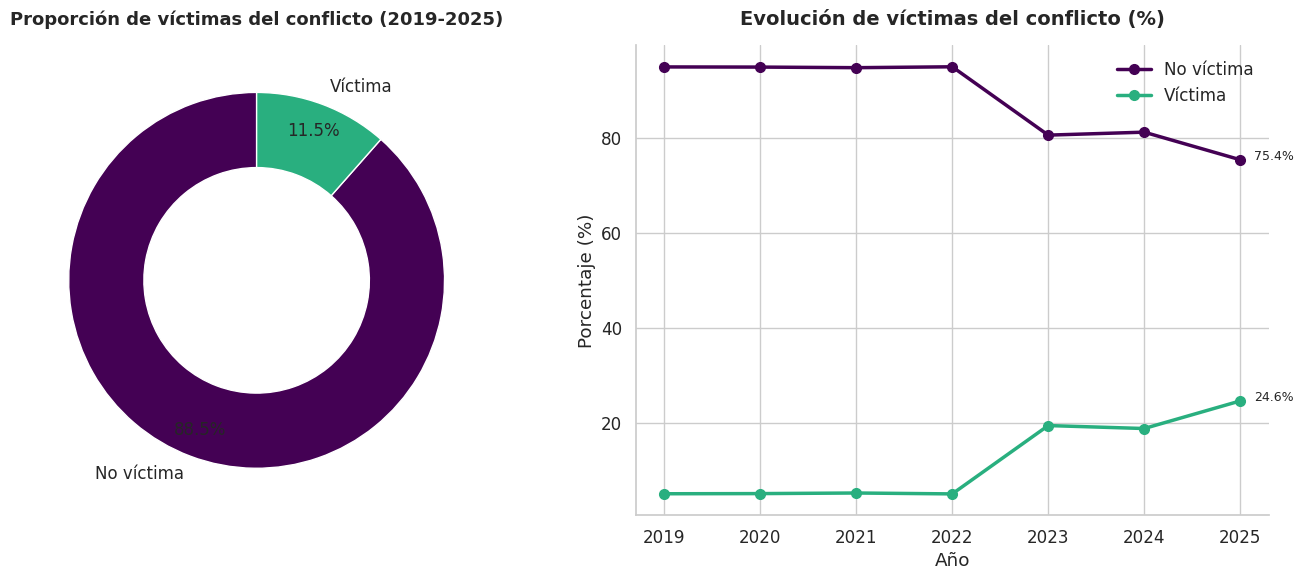


Tabla resumen - Víctimas del conflicto por año:


,No víctima (n),No víctima (%),Víctima (n),Víctima (%)
Año,,,,
2019,"31,647",94.9%,"1,698",5.1%
2020,"32,840",94.9%,"1,774",5.1%
2021,"31,313",94.8%,"1,735",5.2%
2022,"31,163",94.9%,"1,662",5.1%
2023,"24,968",80.6%,"6,026",19.4%
2024,"24,549",81.2%,"5,691",18.8%
2025,"22,036",75.4%,"7,198",24.6%


In [33]:
# ============================================================
# Sección 8: Población Víctima del Conflicto
# ============================================================
# NOTA: La variable VICTIMA ya fue calculada en el bloque anterior
# usando POB_VICT_CONF (2019-2022) y POB_VICT_CONF_RUV (2023-2025)

# --- Distribución general + Evolución temporal ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Torta
victima_conteo = SIMAT['VICTIMA'].value_counts()
victima_conteo = victima_conteo[victima_conteo.index != 'Sin dato']
colores_victima = [palette[0], palette[12]]

axes[0].pie(victima_conteo, labels=victima_conteo.index,
            autopct='%1.1f%%', colors=colores_victima, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Proporción de víctimas del conflicto (2019-2025)',
                  fontsize=13, fontweight='bold', pad=15)

# Evolución temporal
victima_anual = SIMAT[SIMAT['VICTIMA'] != 'Sin dato'].groupby(['ANO_INF', 'VICTIMA']).size().unstack(fill_value=0)
victima_pct = victima_anual.div(victima_anual.sum(axis=1), axis=0) * 100

for i, col in enumerate(victima_pct.columns):
    axes[1].plot(victima_pct.index, victima_pct[col], marker='o', linewidth=2.5,
                 markersize=7, label=col, color=colores_victima[i])
    ultimo = victima_pct[col].iloc[-1]
    axes[1].annotate(f'{ultimo:.1f}%', (victima_pct.index[-1], ultimo),
                     textcoords='offset points', xytext=(10, 0), fontsize=9)

axes[1].set_title('Evolución de víctimas del conflicto (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].legend(frameon=False)
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

print("\nTabla resumen - Víctimas del conflicto por año:")
display(tabla_resumen(SIMAT[SIMAT['VICTIMA'] != 'Sin dato'], 'VICTIMA'))

In [34]:
for año in [2022, 2023, 2024, 2025]:
    df = SIMAT_CALI[(SIMAT_CALI['ES_CIEAVC']) & (SIMAT_CALI['ANO_INF'] == año)]
    if año <= 2022:
        print(f"\n{año} - POB_VICT_CONF:")
        print(df['POB_VICT_CONF'].value_counts().head(10))
    else:
        print(f"\n{año} - POB_VICT_CONF_RUV:")
        print(df['POB_VICT_CONF_RUV'].value_counts())


2022 - POB_VICT_CONF:
POB_VICT_CONF
99.0    31163
1.0      1259
10.0      200
18.0       84
3.0        31
4.0        22
17.0       20
2.0        18
7.0        11
19.0        5
Name: count, dtype: int64

2023 - POB_VICT_CONF_RUV:
POB_VICT_CONF_RUV
NO    24968
SI     6026
Name: count, dtype: Int64

2024 - POB_VICT_CONF_RUV:
POB_VICT_CONF_RUV
NO    24549
SI     5691
Name: count, dtype: Int64

2025 - POB_VICT_CONF_RUV:
POB_VICT_CONF_RUV
NO    22036
SI     7198
Name: count, dtype: Int64


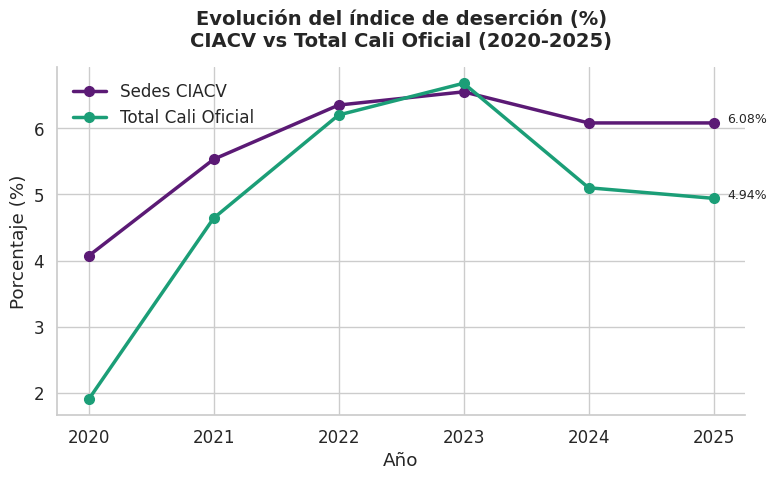

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
anios = np.array([2020, 2021, 2022, 2023, 2024, 2025])
ciacv = np.array([4.07, 5.53, 6.35, 6.55, 6.08, 6.08])
cali = np.array([1.9, 4.64, 6.2, 6.68, 5.1, 4.94])

# Colores similares al esquema anterior
color_ciacv = '#5B1A75'   # Morado oscuro
color_cali = '#1B9E77'    # Verde institucional

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(anios, ciacv, marker='o', linewidth=2.5,
        markersize=7, label='Sedes CIACV', color=color_ciacv)

ax.plot(anios, cali, marker='o', linewidth=2.5,
        markersize=7, label='Total Cali Oficial', color=color_cali)

# Anotar último valor
ax.annotate(f'{ciacv[-1]:.2f}%', (anios[-1], ciacv[-1]),
            textcoords='offset points', xytext=(10, 0), fontsize=9)

ax.annotate(f'{cali[-1]:.2f}%', (anios[-1], cali[-1]),
            textcoords='offset points', xytext=(10, 0), fontsize=9)

ax.set_title('Evolución del índice de deserción (%)\nCIACV vs Total Cali Oficial (2020-2025)',
             fontsize=14, fontweight='bold', pad=15)

ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(anios)
ax.legend(frameon=False)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()
